* https://www.youtube.com/watch?v=ZBKpAp_6TGI
* https://github.com/hkproj/pytorch-stable-diffusion?tab=readme-ov-file
* 가중치 및 토크나이저 다운로드: https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/tree/main 
  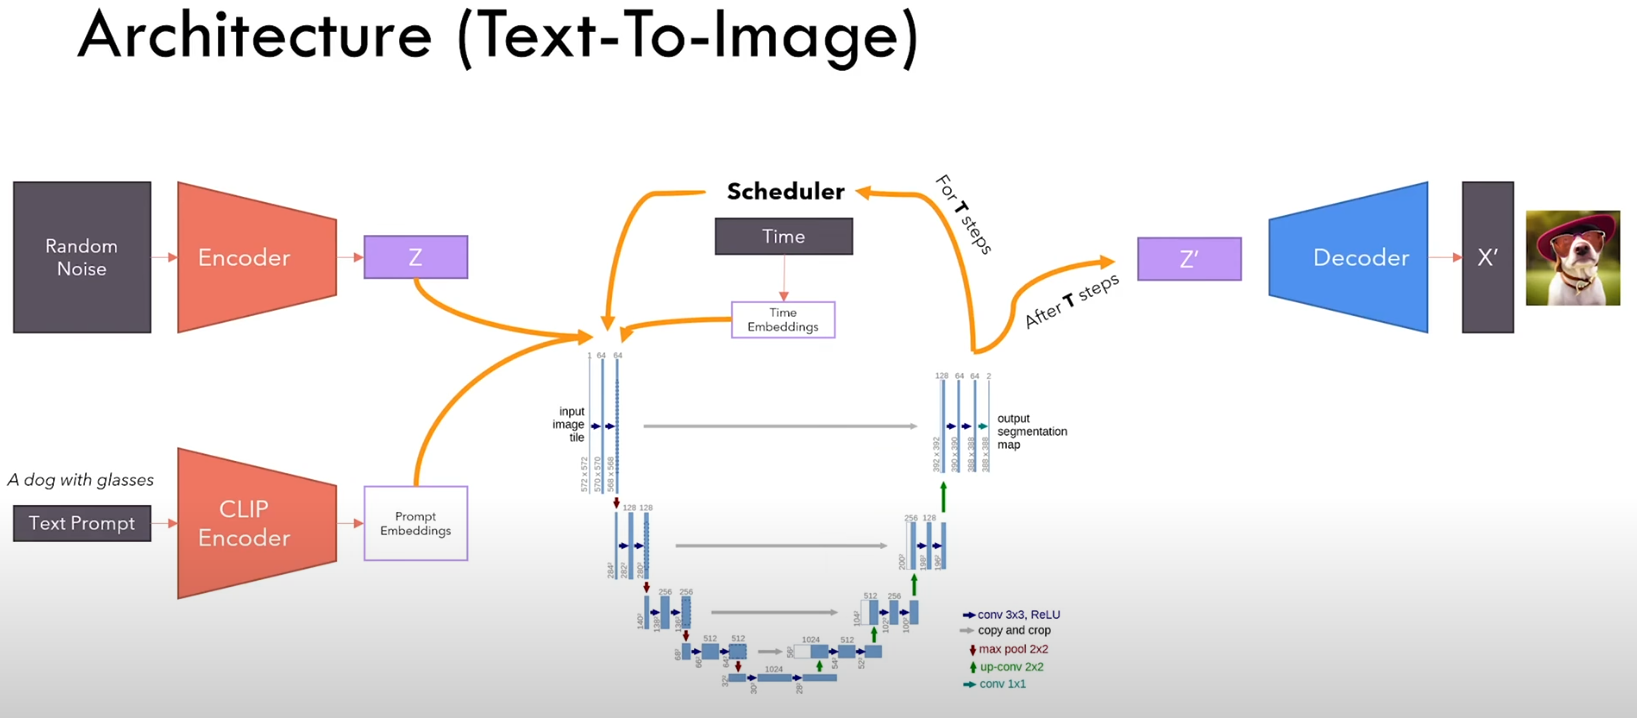
  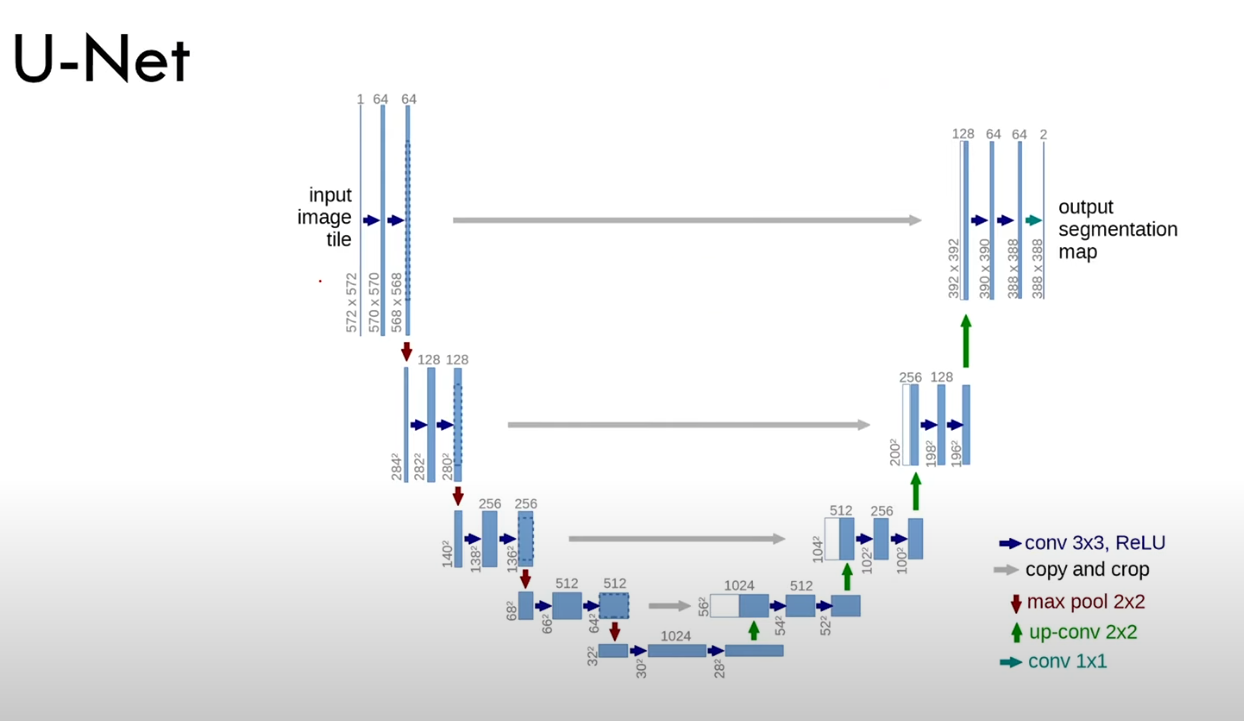

### ***** “원조 U-Net(세그멘테이션)” vs “Stable Diffusion 파이프라인(= VAE + 확산 U-Net)”은 서로 다른 두 모델" *****
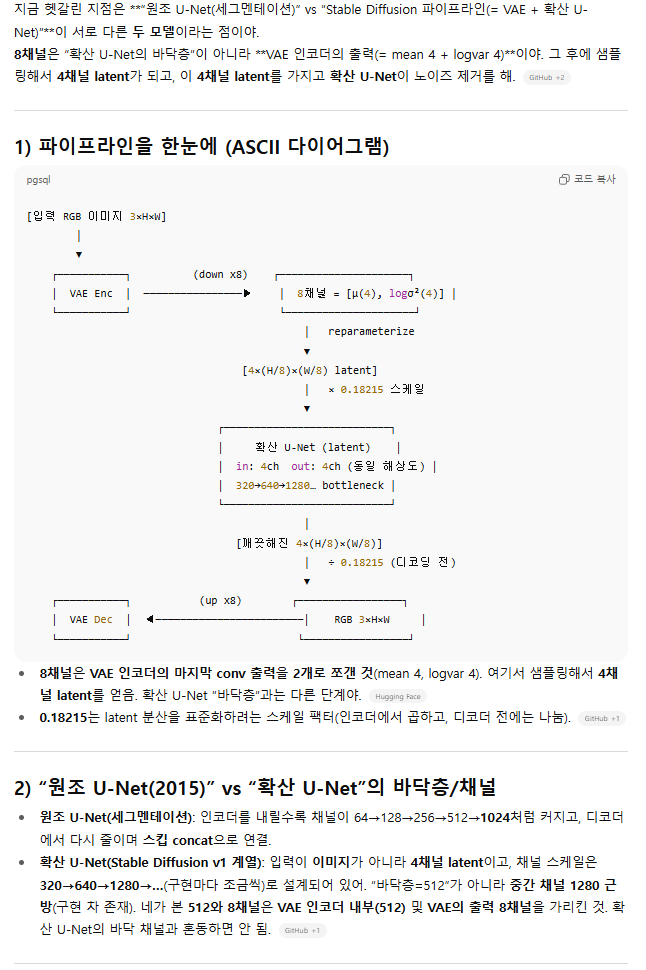
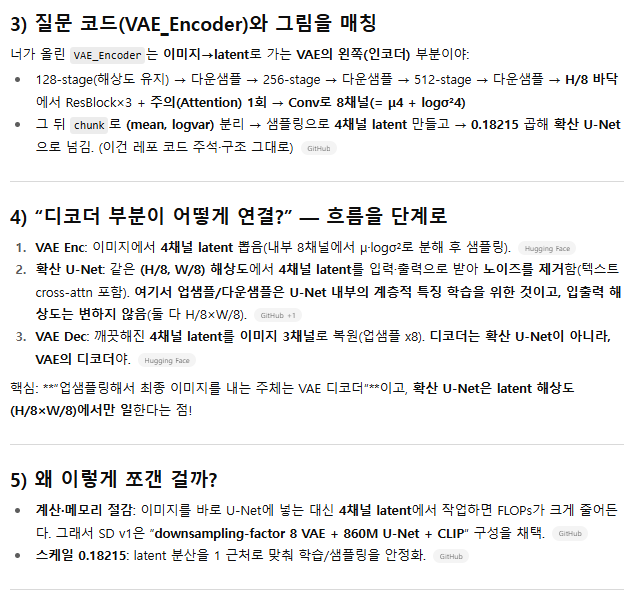

## ***** “텍스트 임베딩(= CLIP) → 확산 U-Net 결합”을 ASCII 다이어그램 *****
## "텍스트 임베딩과 확산 Unet은 어디서 만나는가??"
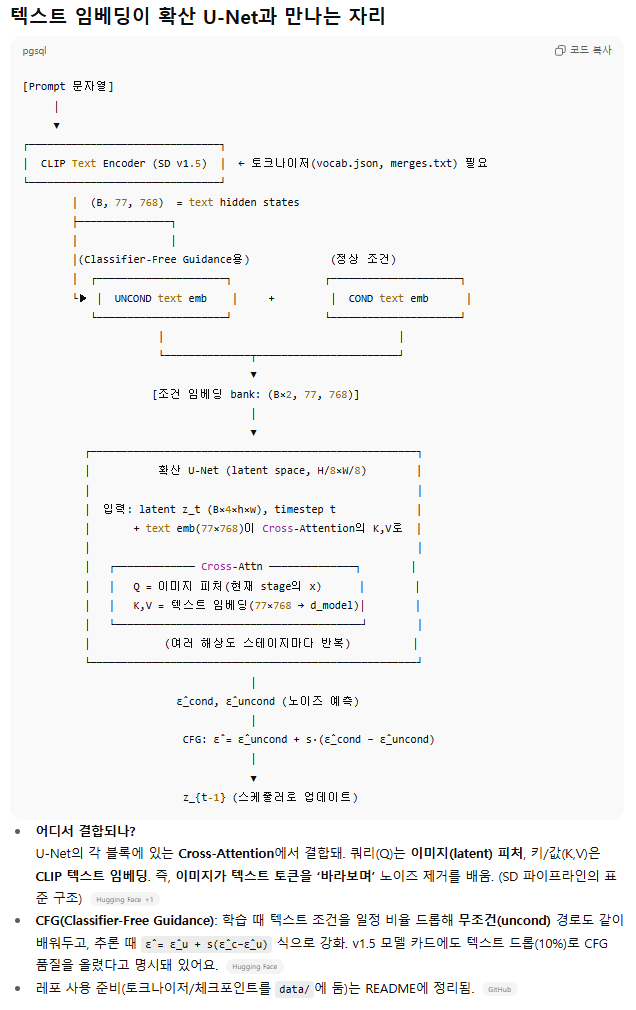

* cnn 작동원리 참고 사이트:  https://ezyang.github.io/convolution-visualizer/ 

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
import math

# **SelfAttention(n_heads=1, d_embed=512)**일 때 모양과 연산을 단계별로 쪼개 설명 (배치 B, 시퀀스 길이 T로 표기)
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # 입력 x: (B, T, 512) / T는 이미지 h*w 길이임 
        # 헤드 수 H = 1 → 헤드 차원 d_head = 512 // 1 = 512
        # 가중치:
        #     in_proj: Linear(512 → 3×512) → 한 번에 Q/K/V를 뽑는다 (Wq, Wk, Wv를 한 층으로 합침)
        #     out_proj: Linear(512 → 512) → 모든 헤드의 출력을 합쳐 최종 투영(여기선 H=1이라 그대로)

        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H) / (개, 단, 헤, 차)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)   # (B, T, 1, 512)

        # Q/K/V 만들기
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
            # in_proj(x) 결과: (B, T, 1536)
            # chunk(3, -1)로 쪼개서
            # q, k, v: 각각 (B, T, 512)
        
        # 개,단,헤,차 -> 개,헤,단,차
        # 일반적으로 H>1이면 (B, H, T, d_head)가 되어 “여러 헤드”로 병렬 계산을 하는데, 지금은 H=1이라 실질적으로 한 헤드
        q = q.view(interim_shape).transpose(1, 2)    # q.view(B, T, 1, 512).transpose(1, 2)  # (B, 1, T, 512)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (B, 1, T, 512) @ (B, 1, 512, T) = (B, 1, T, T)
        weight = q @ k.transpose(-1, -2)   
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)            # 상삼각(자기 이후 토큰) 마스킹
            # 미래 토큰을 보지 못하게 상삼각 부분을 -inf로 채워 softmax 후 0이 되게 함.
            weight.masked_fill_(mask, -torch.inf) 
        
        # 스케일링 
        # # 여기선 sqrt(512)
        weight /= math.sqrt(self.d_head) 

        # Softmax 
        weight = F.softmax(weight, dim=-1) # (B, 1, T, T)

        # 가중합으로 값 집계 (V에 가중치 적용) 
        # 각 쿼리 토큰이 소프트맥스된 가중치로 **모든 토큰의 값(V)**를 섞어서 문맥 벡터를 만든다.
        output = weight @ v                # (B, 1, T, 512)

        # 헤드 결합 및 최종 투영
        output = output.transpose(1, 2)       # (B, T, 1, 512)
        output = output.reshape(input_shape)  # (B, T, 512)  # H=1이라 그냥 펼침
        # 여러 헤드면 (B, T, H*d_head)로 이어 붙인 뒤 out_proj로 섞지만, H=1이면 사실상 그냥 선형 변환 한 번.
        output = self.out_proj(output)        # (B, T, 512)
        
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

## ***** Attention 도식화 *****
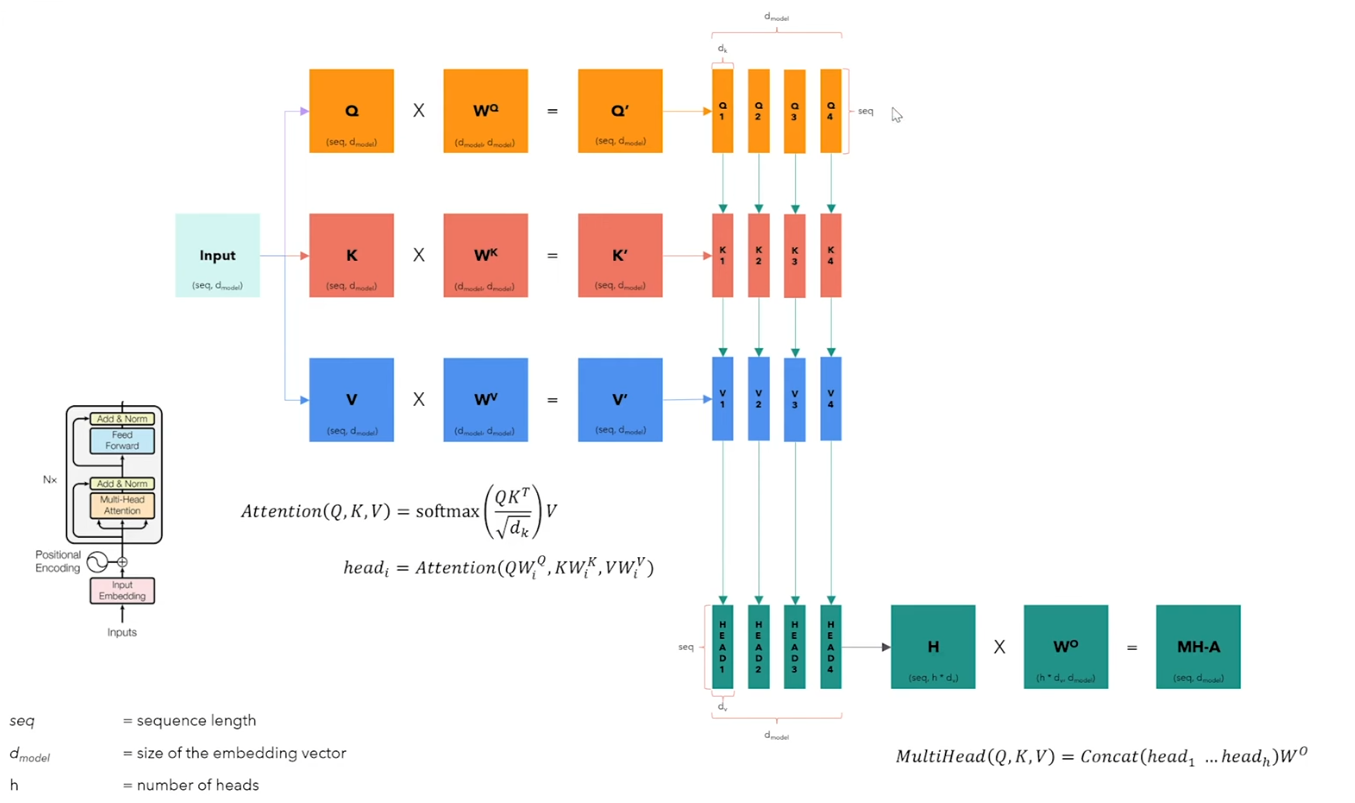
## ****************************

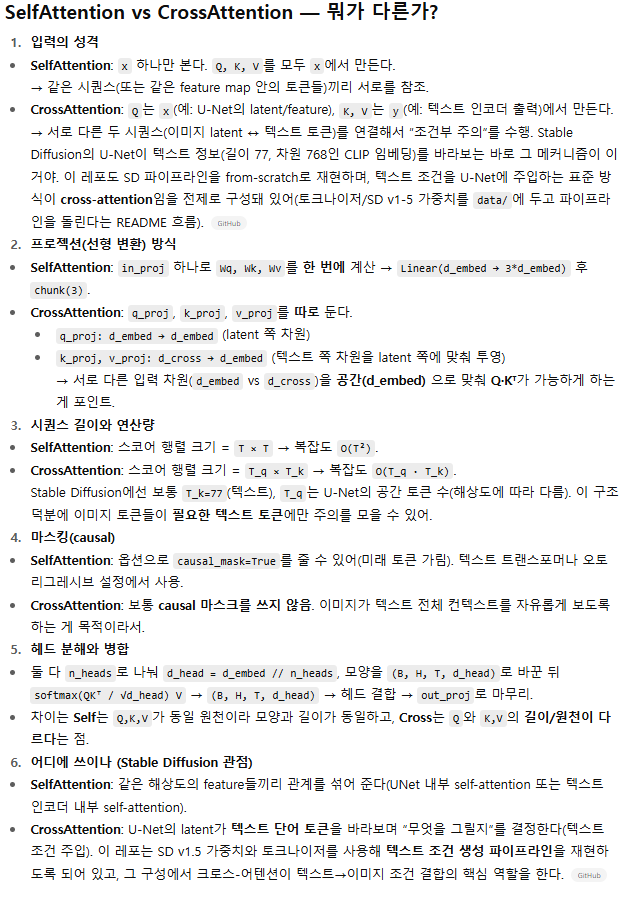

In [8]:

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)  # channels이 512일때 attention 사이즈는 (B, T, 512)
    
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)   # (B, T, 512)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x 

## VAE_ResidualBlock(128, 128)가 입력 (B, 128, H, W)를 받을 때를 가정 
## VAE_ResidualBlock(128, 128)인 경우 위 그림의 U-Net에서 채널이 128인 해상도 스테이지(파란색 3×3 conv×2 블록)에 해당
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)   # GroupNorm(32, 128) → 채널 128을 32개 그룹으로 나눔 ⇒ 그룹당 4채널(128/32=4)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()    # (1×1 Conv 불필요) / nn.Identity()는 아무 연산도 하지 않고 입력을 그대로 반환하는 모듈
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)
        # 스킵에 더하기 위해 원본 보관. 모양: (B, 128, H, W)
        residue = x   

        # 배치 크기와 무관한 정규화(소배치에서도 안정) / (B, 128, H, W)
        x = self.groupnorm_1(x)
        
        x = F.silu(x)
        
        # x = Conv3×3(128→128, pad=1)(x) / (B, 128, H, W)
        x = self.conv_1(x)
        
        x = self.groupnorm_2(x)
        
        x = F.silu(x)
        
        # x = Conv3×3(128→128, pad=1)(x) / (B, 128, H, W)
        x = self.conv_2(x)
        
        # out = x + Identity(residue) / (B, 128, H, W)
        # 해상도와 채널 수 그대로 유지하는 잔차 블록
        return x + self.residual_layer(residue)
            ### 원래(2015) U-Net에는 블록 내부의 **짧은 스킵(잔차 덧셈)**이 없었어.!!
            # 인코더↔디코더 사이의 긴 스킵은 concat으로 이어 붙이는 방식이었지. 
            # 그런데 **확장된 U-Net들(특히 확산모델용 U-Net)**에서는 각 해상도 단계에 **Residual block(= 짧은 스킵, x + F(x))**을 넣는 게 표준이 되었어.
            # Stable Diffusion의 U-Net도 GroupNorm+SiLU가 들어간 잔차 블록을 반복해서 쓰고,
            # 인코더↔디코더의 긴 스킵은 여전히 concat 후 Conv/ResBlock으로 융합하는 구조야.



In [9]:

### 이 클래스는 nn.Sequential(...) 안에 인코더 파이프라인을 “차례대로 나열” 해 둔 거야.
# 스텝별로 묶어 보면 훨씬 단순해:
    # [입구] 3→128 conv
    # [128 스테이지] Res(128→128) ×2
    # [Down] stride2 conv (+비대칭 pad)
    # [256 스테이지] Res(128→256), Res(256→256)
    # [Down] stride2 conv
    # [512 스테이지] Res(256→512), Res(512→512)
    # [Down] stride2 conv
    # [바닥층] Res(512→512) ×3, Attention(512), GN, SiLU, Conv(512→8, k3,p1), Conv(8→8, k1)
    # [출구] chunk → (mean, logvar) → reparam → ×0.18215
# 이렇게만 기억하면 돼:
    # “해상도 3번 반으로 줄이고(//2, //4, //8), 채널은 128→256→512로 올리고, 맨 아래서 잔차+어텐션으로 한 번 더 섞은 뒤 8채널(=4+4) 파라미터를 뽑는다.”

### 인코더는 평균과 분산이다.
class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512),   ## → 공간 어텐션으로 전역 문맥 반영(바닥층에서 한 번)
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(512, 8, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0), 
        )

    def forward(self, x, noise):
        # x: 이미지 텐서 (B, 3, H, W)
        # noise: 정규분포 N(0,1)에서 뽑은 잡음 텐서 (B, 4, H/8, W/8)

        ## 코드 상단에서 nn.Sequential(...)로 인코더 전체 레이어를 한 배열로 만들어뒀고, forward에서는 그 배열을 그대로 for 루프로 돕니다.
        for module in self:
            if getattr(module, 'stride', None) == (2, 2):  
                # module에 stride가 없으면 None을 반환하고 stride가 값이 정확히 (2, 2) 인지 확인
                # PyTorch의 nn.Conv2d는 stride를 항상 튜플로 들고 있음
                
                x = F.pad(x, (0, 1, 0, 1))   # (padding_left, padding_right, padding_top, padding_bottom)
            
            x = module(x)
                ## 여기서 핵심 두 가지:
                    # 다운샘플 직전 비대칭 패딩
                        # stride=2, kernel=3, padding=0인 Conv를 통과하기 직전에만 pad=(left=0, right=1, top=0, bottom=1)를 적용.
                        # 이유: 가장자리 손실/홀수 해상도에서 생길 수 있는 off-by-one 이슈를 막고, 정확히 절반 해상도가 나오도록 보정.
                        # 다른 레이어들은 그대로 통과
                        # ResBlock/Attention/GN/SiLU/Conv(k=3,p=1) 등은 패딩 없이 진행.
                    # 이 반복으로 H, W가 → H/2 → H/4 → H/8로 줄고, 채널은 →128→256→512로 커짐(초기화 부분에서 본 그 순서 그대로).
                    # 루프가 끝나면 x는 (B, 8, H/8, W/8) 가 되어 있음.
                        # (마지막 두 Conv가 8채널을 만든 상태: 8 = mean(4) + logvar(4))
            
        # 평균/로그분산 분리 / 각 (B, 4, H/8, W/8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # 분산 안정화(클램프)
        # log σ²를 [-30, 20]로 제한 → σ² 범위가 대략 [≈1e-13, ≈4.85e8]로 안정
        log_variance = torch.clamp(log_variance, -30, 20)
        # 표준편차 계산
        variance = log_variance.exp()    # σ²
        stdev = variance.sqrt()          # σ
        
        # Reparameterization trick (샘플링)
        # noise ~ N(0,1)를 이용해 z ~ N(μ, σ) 샘플 생성 -> 이게 잠복(latent) 4채널
        x = mean + stdev * noise         # (B, 4, H/8, W/8)
        
        # 스케일 팩터 적용
        # Stable Diffusion v1 계열에서 latent의 스케일을 표준화하려고 쓰는 상수
        x *= 0.18215
        
        return x     ## 최종 반환: (B, 4, H/8, W/8) — 향후 확산 U-Net의 첫 conv가 4→320으로 올려서 내부 모델 차원에 맞춤

## *** "VAE_Encoder 해설" ***
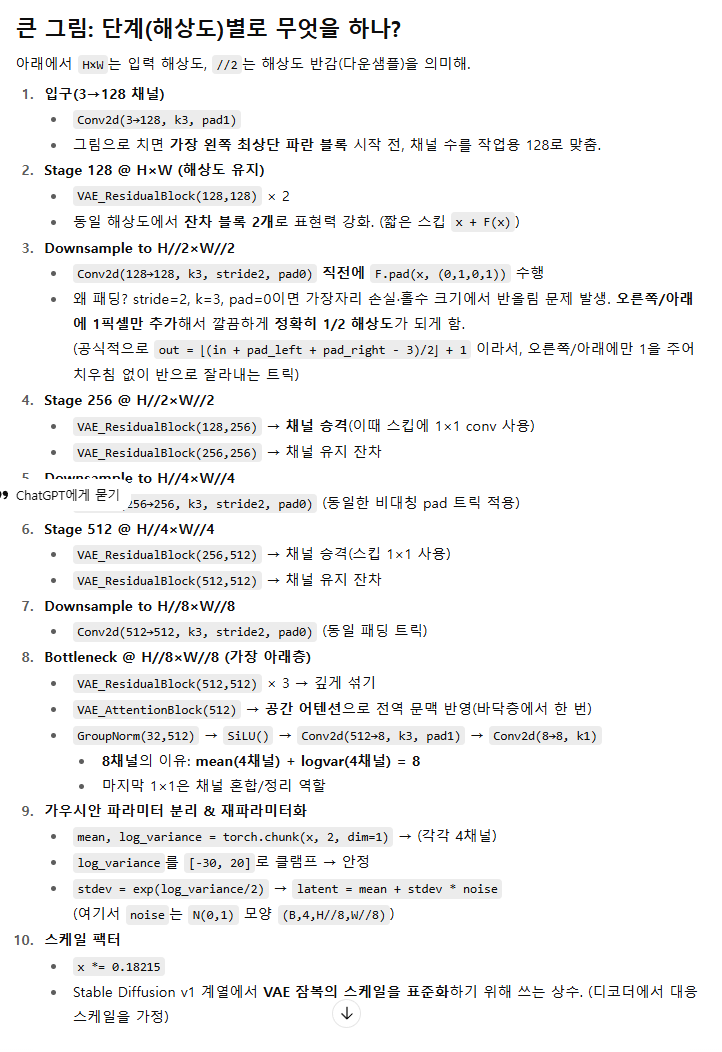

In [11]:
### 역할 : 
# **“텍스트 → 이미지”**는 Stable Diffusion 파이프라인이 텍스트 조건을 준 채로 latent(4채널) 노이즈를 점점 정리한 다음,
# VAE 디코더로 RGB로 복원하는 과정이야.

class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            nn.Conv2d(4, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            
            nn.Upsample(scale_factor=2), 
                # (기본값 mode='nearest') 는 세로/가로 크기를 2배로 키워요. 채널 수는 그대로 두고, 행·열을 그대로 복제(nearest)합니다.
                # 단순히 해상도만 키운 뒤 바로 Conv2d/ResidualBlock을 붙여 **복제로 생길 수 있는 블록감(계단 현상)**을 매끈하게 보정합니다.
                # mode='bilinear' 등을 쓰면 보간(새 값을 만들어 부드럽게)하게 됩니다. 이 코드에선 nearest 업샘플 + Conv로 후처리 전략이라고 보면 돼요.
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 256),
            VAE_ResidualBlock(256, 256),
            VAE_ResidualBlock(256, 256),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            VAE_ResidualBlock(256, 128),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
                # 128개 채널을 32개 “그룹”으로 나눠(=그룹당 4채널), 각 그룹마다 평균·분산을 구해 정규화한 뒤,
                # 채널별로 학습가능한 스케일(γ)·시프트(β) 를 적용하는 층이야. 배치 크기에 덜 민감해서 소배치에서도 안정적이야.
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),         
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        
        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x
        

## ***** "nn.GroupNorm(32, 128) 작동원리??" *****
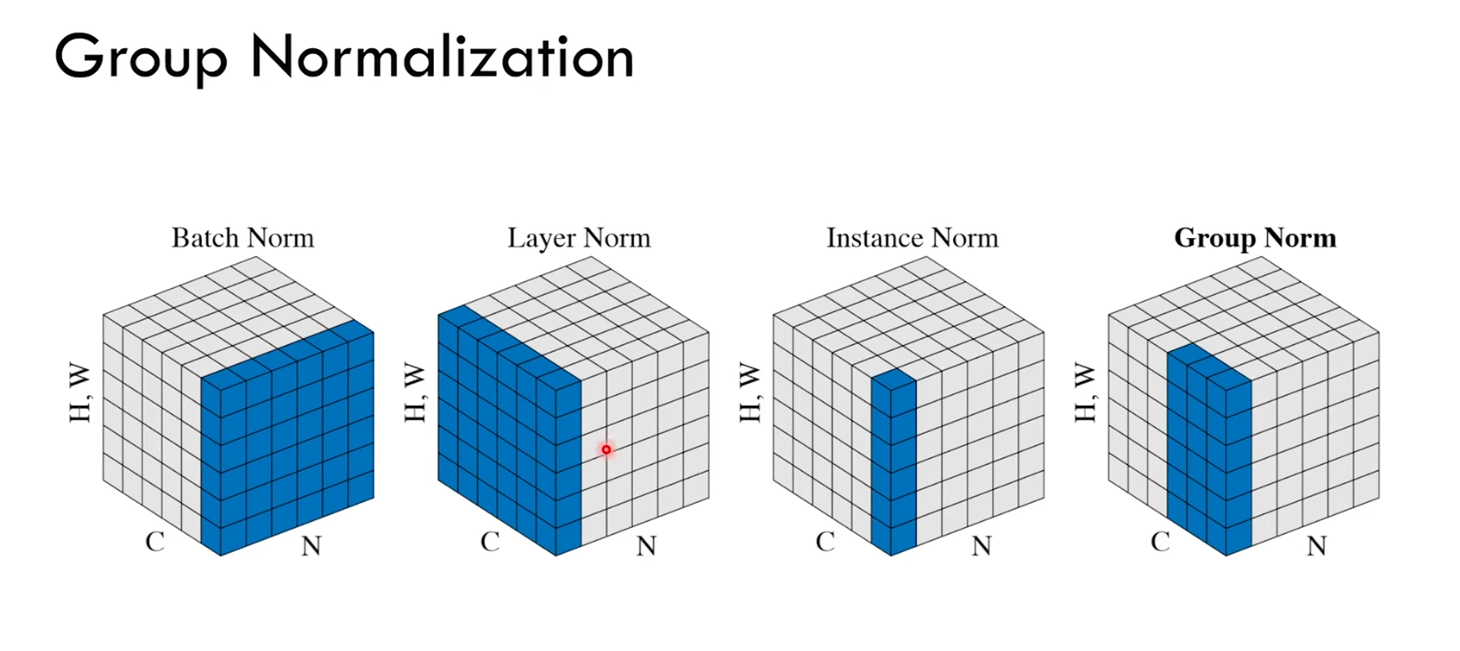
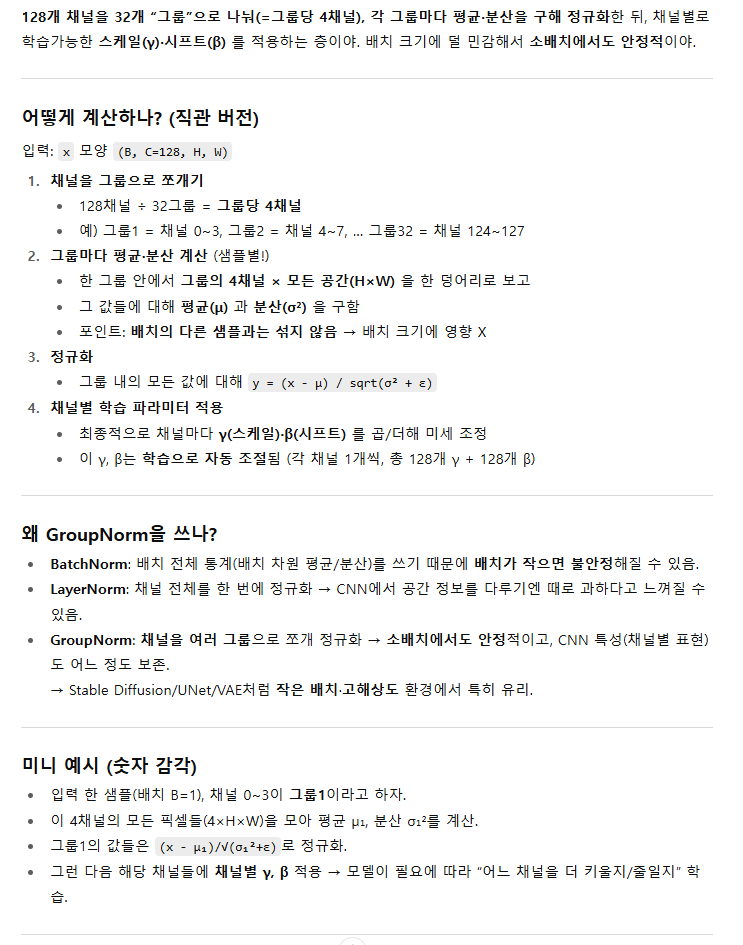

## *********** CLIP ***********
## 질문1. "이미 학습된 가중치는 언제 가져오는건가??"
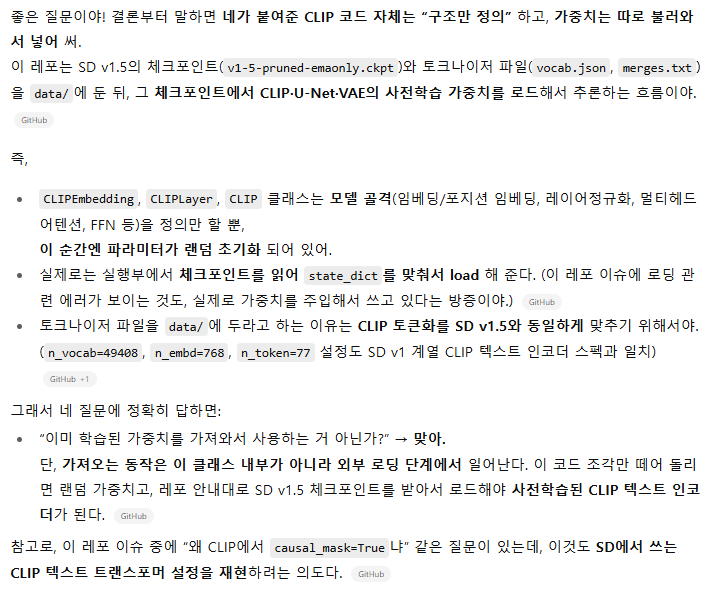
## *******************************
## 질문2. "원조 CLIP모델 구조와 다른거 같아!!"
## "아래 CLIP모델 구조는 프롬프트 텍스트 텐서만 입력값으로 사용하네..."
* 원조 모델 이미지 인코더는 VIT 모델을 사용
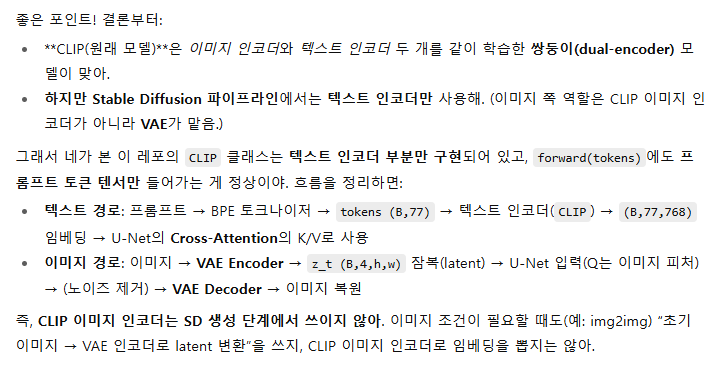

In [14]:
import torch
from torch import nn
from torch.nn import functional as F

class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):  ## CLIPEmbedding(49408, 768, 77) 초기화하여 사용함 
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)      # nn.Embedding(49408, 768)
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))   # (77, 768)

    def forward(self, tokens):    ## tokens는 텍스트 프롬프트가 토크나이저를 거쳐 나온 “정수 토큰 ID” 텐서
                                  ## 형태: torch.LongTensor 크기 (B, 77) / Stable Diffusion v1 계열 CLIP 텍스트 인코더는 최대 시퀀스 길이 77로 고정
        x = self.token_embedding(tokens)   # (B, 77, 768) 임베딩 벡터로 변환
        x += self.position_embedding

        return x

## ***** x = self.token_embedding(tokens) 이 부분의 작동원리 *****
## "tokens 입력값이 어떻게 (B, 77, 768) 임베딩 벡터로 변환되나??"
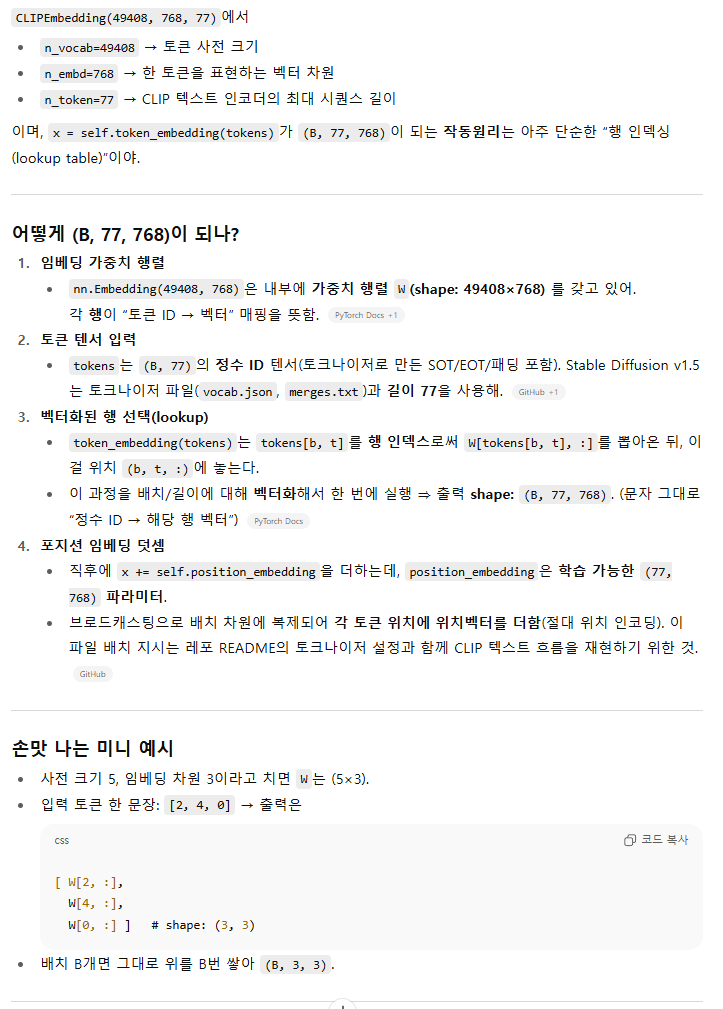

In [16]:
### 내가 정의한 CLIPLayer:
### 프롬프트 텐서(배치, 토큰수(77)))를 입력받아 임베딩을 거쳐 사이즈 변화(배치, 토큰수, 차원수)를 주고, 이 입력값을
### 셀프어텐션(헤드12개) 헤드 개수만큼 돌려 아웃풋(배치, 토큰수, 차원수) 반환

class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()

        self.layernorm_1 = nn.LayerNorm(n_embd)
        self.attention = SelfAttention(n_head, n_embd)
        self.layernorm_2 = nn.LayerNorm(n_embd)
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    ## ① 셀프어텐션(잔차 더하기) → ② 피드포워드(잔차 더하기) 구조
    def forward(self, x):
        ## 셀프어텐션(Pre-LN)
        residue = x

        
        x = self.layernorm_1(x)
        x = self.attention(x, causal_mask=True)  # causal_mask=True → 자기보다 “이후 토큰”은 못 보게 가림(오토리그레시브 성격)
        x += residue                             # 짧은 스킵(Residual add) 로 정보/그라디언트 보존

        ## 피드포워드(Pre-LN + 두 개의 선형층 + 활성화)
        residue = x

        x = self.layernorm_2(x)
        x = self.linear_1(x)
        x = x * torch.sigmoid(1.702 * x)         # ← QuickGELU / GELU 품질을 빠르고 간단하게 얻기 위한 선택
        x = self.linear_2(x)
        x += residue

        return x

### 핵심: x * sigmoid(1.702 * x)가 뭐길래?
    # 이건 GELU 활성화의 빠른 근사치, 흔히 QuickGELU라고 불러.
    # 의미: 값을 “부드럽게 문지르는 ReLU”라고 생각하면 좋아.
        # 큰 양수 → sigmoid(1.702x) ≈ 1 → 대체로 그대로 통과(x * 1)
        # 0 부근 → 시그모이드가 0.5 근처 → 절반 정도만 통과
        # 음수 → 시그모이드가 0에 가까워져서 강하게 줄이거나 거의 막음
    # 왜 1.702? 시그모이드를 적당히 눌러서 원래 GELU(가우시안 기반) 곡선과 모양/기울기가 잘 맞도록 튜닝된 상수야. 계산이 빠르고 학습도 잘 됨.
    # 숫자 감각 미니 예시
        # x = 2.0 → sigmoid(1.702*2)=sigmoid(3.404)≈0.967 → 출력 ≈ 2.0 * 0.967 = 1.93 (거의 그대로)
        # x = 0.0 → sigmoid(0)=0.5 → 출력 0 * 0.5 = 0 (중립)
        # x = -2.0 → sigmoid(-3.404)≈0.032 → 출력 ≈ -2.0 * 0.032 = -0.064 (강하게 억제)
    # 즉, 양수는 통과, 음수는 부드럽게 눌러주는 “게이트” 역할이라고 보면 된다.


class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)

        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])

        self.layernorm = nn.LayerNorm(768)
    
    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)

        # Apply encoder layers similar to the Transformer's encoder.
        for layer in self.layers: 
            # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
            state = layer(state)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.layernorm(state)
        
        return output      # output → (B, 77, 768)

        

In [17]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)
            # get_timestep_embedding(t, dim=320) 같은 함수(이 레포의 다른 위치/유틸)에서
            # 로그-스페이스 주파수로 sin/cos 값을 쭉 만들어 길이 320짜리 벡터
        x = self.linear_1(x)    # (1, 320) -> (1, 1280)
        x = F.silu(x)
        x = self.linear_2(x)

        return x                # (1, 1280)

In [18]:
##### 아래 UNET_ResidualBlock 코드 예제 _ nn.Linear(n_time, out_channels) #####
# 임의 feature (B=2, C_in=3, H=4, W=5)
# Conv2d(3→6)로 feature_after_conv (B,6,H,W)
# time (1,1280) → SiLU → Linear(1280→6)로 time_projected (1,6)
# unsqueeze로 (1,6,1,1) 만든 뒤 브로드캐스트 더하기 → merged (B,6,H,W)


# Demonstration of how time embedding is projected and broadcast-added to feature maps

import torch
import torch.nn as nn
import torch.nn.functional as F

# Reproducibility
torch.manual_seed(0)

# ---------------------
# 1) Create dummy inputs
# ---------------------
B, C_in, H, W = 2, 3, 4, 5      # batch, in-channels, height, width
C_out = 6                       # out-channels after conv
n_time = 1280                   # time embedding width

feature = torch.randn(B, C_in, H, W)      # (B, C_in, H, W)
time = torch.randn(1, n_time)             # (1, 1280)

print("Input shapes:")
print(" feature:", tuple(feature.shape))
print(" time   :", tuple(time.shape))

# ---------------------
# 2) Feature path: Conv2d(C_in -> C_out)
# ---------------------
conv_feature = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)  # keep H,W
feature_after_conv = conv_feature(feature)                       # (B, C_out, H, W)

print("\nAfter Conv2d(C_in->C_out):")
print(" feature_after_conv:", tuple(feature_after_conv.shape))

# ---------------------
# 3) Time path: SiLU then Linear(1280 -> C_out)
# ---------------------
linear_time = nn.Linear(n_time, C_out)

time_after_silu = F.silu(time)               # (1, 1280)
time_projected  = linear_time(time_after_silu)  # (1, C_out)

print("\nTime path:")
print(" time_after_silu :", tuple(time_after_silu.shape))
print(" time_projected  :", tuple(time_projected.shape))

# ---------------------
# 4) Unsqueeze to (1, C_out, 1, 1) and broadcast-add
# ---------------------
time_broadcast = time_projected.unsqueeze(-1).unsqueeze(-1)  # (1, C_out, 1, 1)
merged = feature_after_conv + time_broadcast                  # (B, C_out, H, W)

print("\nBroadcast add:")
print(" time_broadcast:", tuple(time_broadcast.shape))
print(" merged        :", tuple(merged.shape))

# ---------------------
# 5) Verify per-channel constant offset across spatial locations
#    For each channel c, merged[:,c,:,:] - feature_after_conv[:,c,:,:] == time_projected[0,c]
# ---------------------
diff = merged - feature_after_conv                            # (B, C_out, H, W)
# Compute spatial std per channel to show it's constant across HxW
spatial_std = diff.view(B, C_out, -1).std(dim=-1)

print("\nSanity check (should be ~0 if constant across HxW):")
print(" per-batch, per-channel spatial std of (merged - feature):")
print(spatial_std)

# Show the actual bias added for the first batch, first two channels
print("\nExample biases added (first batch):")
for c in range(min(2, C_out)):
    print(f" channel {c}: added bias ≈ {time_projected[0, c].item():.6f}, "
          f"sample merged[0,{c},0,0]-feature_after_conv[0,{c},0,0] ≈ "
          f"{(merged[0,c,0,0]-feature_after_conv[0,c,0,0]).item():.6f}")


Input shapes:
 feature: (2, 3, 4, 5)
 time   : (1, 1280)

After Conv2d(C_in->C_out):
 feature_after_conv: (2, 6, 4, 5)

Time path:
 time_after_silu : (1, 1280)
 time_projected  : (1, 6)

Broadcast add:
 time_broadcast: (1, 6, 1, 1)
 merged        : (2, 6, 4, 5)

Sanity check (should be ~0 if constant across HxW):
 per-batch, per-channel spatial std of (merged - feature):
tensor([[1.1743e-08, 3.0423e-08, 1.6466e-08, 1.1941e-08, 1.3007e-08, 1.6466e-08],
        [1.1743e-08, 2.3486e-08, 1.9034e-08, 8.9145e-09, 1.3230e-08, 2.1349e-08]],
       grad_fn=<StdBackward0>)

Example biases added (first batch):
 channel 0: added bias ≈ -0.228324, sample merged[0,0,0,0]-feature_after_conv[0,0,0,0] ≈ -0.228324
 channel 1: added bias ≈ -0.694865, sample merged[0,1,0,0]-feature_after_conv[0,1,0,0] ≈ -0.694865


In [19]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)
            # 시간 임베딩(길이 1280)을 현재 블록의 채널 수(out_channels)에 맞는 1D 벡터로 투영해서,
            # **특징맵에 더해줄 “채널별 시간 바이어스”**를 만들어주는 층이야.
            # 즉, 타임스텝에 따라 채널별로 다른 편향을 주는 조건부(residual) 보정을 한다고 보면 돼.
            # 블록 내부:
                # feature를 Conv2d(C_in → C_out)로 변환 → feature: (B, C_out, H, W)
                # time = SiLU(time) (비선형성 추가)
                # 핵심: time = Linear(1280 → C_out)
                # 결과: time: (1, C_out)
                # time.unsqueeze(-1).unsqueeze(-1) → (1, C_out, 1, 1)로 만들어 공간에 브로드캐스트 가능하게 함
                # merged = feature + time → 각 채널마다 같은 값(시간에 따라 달라지는 편향)이 (H, W) 전 위치에 더해짐
                # 모양: (B, C_out, H, W)
                # 이후 GroupNorm → SiLU → Conv를 거쳐 출력으로 나감.

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()    # nn.Identity()는 아무 연산도 하지 않고 입력을 그대로 반환하는 모듈
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (B, 320, h, w) (여기서 h=H/8, w=W/8) 일 경우 사이즈 변화 
        # time: (1, 1280)

        residue = feature

        feature = self.groupnorm_feature(feature)              # (B, 320, h, w)
        feature = F.silu(feature)
        feature = self.conv_feature(feature)                   # Conv2d(320→320, k=3, p=1)(feature)  # (B, 320, h, w)

        time = F.silu(time)                                    # (1, 1280)
        time = self.linear_time(time)                          # Linear(1280→320)(time)            # (1, 320)
        
        ## 피처 + 시간(조건 주입)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)    # time.unsqueeze(-1).unsqueeze(-1)  # (1, 320, 1, 1) -> (B, 320, h, w)
        merged = self.groupnorm_merged(merged)                 # (B, 320, h, w)
        merged = F.silu(merged)
        merged = self.conv_merged(merged)                      # Conv2d(320→320, k=3, p=1)(merged)  # (B, 320, h, w)
        
        return merged + self.residual_layer(residue)
            ## 잔차 더하기(Short skip)
            ## in==out이므로 merged + Identity(residue)         # (B, 320, h, w)
        
        

In [20]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)   # 2로 청크하여 사용하기 때문에 2를 곱함 
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)
        ## 입력 x는 (B, 320, h, w)(여기서 h=H/8, w=W/8), context는 CLIP 출력 (B, 77, 768)이 들어온다고 가정하고 모양 중심으로 단계별로 따라가 보자.
        ## UNET_AttentionBlock(8, 40)일 경우 channels = n_head * n_embd = 8 * 40 = **320**

        # 롱 스킵 저장: 블록 처음 입력을 마지막에 다시 더하기 위해 보관(블록 바깥쪽 잔차)
        residue_long = x

        x = self.groupnorm(x)         # GroupNorm(32, 320)(x)                 # (B, 320, h, w)
        x = self.conv_input(x)        # Conv2d(320→320, k=1)(x)               # (B, 320, h, w)
        n, c, h, w = x.shape
        x = x.view((n, c, h * w))                                             # (B, 320, T)   ; T=h*w
        x = x.transpose(-1, -2)       # (개, 단, 차)                           # (B, T, 320)

        # (Self-Attn 경로) Pre-LN → Self-Attention → 잔차
        residue_short = x
        x = self.layernorm_1(x)                                               # (B, T, 320)
        x = self.attention_1(x)       # SelfAttention(H=8, Dim=320)(x)        # (B, T, 320)
            # 헤드 분해 관점:
            # q,k,v 각각 (B, T, 320) → (B, T, 8, 40) → (B, 8, T, 40)
            # 어텐션 가중치 (B, 8, T, T) → 출력 다시 (B, T, 320)
        x += residue_short

        # (Cross-Attn 경로) Pre-LN → Cross-Attention → 잔차
        residue_short = x
        x = self.layernorm_2(x)                                               # (B, T, 320)
        x = self.attention_2(x, context)   # CrossAttention(H=8, Dim=320, d_context=768)(x, context)  # (B, T, 320)
            # 여기서 텍스트가 결합된다.
            # Q: 현재 이미지 토큰 x → (B, T, 8, 40)
            # K,V: context (B, 77, 768)을 내부 선형으로 (B, 77, 8, 40)로 투영
            # 어텐션 가중치 크기: (B, 8, T, 77)
            # → 이미지의 각 공간 토큰이 77개 텍스트 토큰을 “바라보며” 정보를 끌어온다.
        x += residue_short

        # (FFN 경로) Pre-LN → GeGLU → Linear → 잔차
        residue_short = x
        x = self.layernorm_3(x)                                               # (B, T, 320)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)   # Linear(320→ 4*320*2)(x).chunk(2, dim=-1)  # 둘 다 (B, T, 1280)
        x = x * F.gelu(gate)                                                  # GeGLU: (B, T, 1280)
        x = self.linear_geglu_2(x)    # Linear(1280→320)(x)                   # (B, T, 320)
        x += residue_short
            # self.linear_geglu_1층이 채널을 8배(4×채널 × 2묶음)로 키운 뒤, 절반은 값(x), 절반은 게이트(gate) 로 사용.
            # 게이트로 누르기/통과시키기 (GeGLU)
                # F.gelu(gate)는 부드러운 활성화.
                # gate가 크게 양수면 gelu(gate) ≈ 1 → 잘 통과
                # gate가 작거나 음수면 ≈ 0 → 강하게 억제
                # 결과적으로, 각 토큰·채널마다 얼마나 정보를 보낼지를 게이트가 결정.
            # linear_geglu_2로 다시 원 채널(320)로 축소.
            # 토큰별 비선형 변환(용량↑) 후 잔차로 안정화.

        x = x.transpose(-1, -2)                         # (B, 320, T)
        x = x.view((n, c, h, w))                        # (B, 320, h, w)

        return self.conv_output(x) + residue_long
            # y = Conv2d(320→320, k=1)(x)               # (B, 320, h, w)
            # out = y + residue_long                     # (B, 320, h, w)
        
        
### 한 장 요약(모양 흐름)
# 입력 (B, 320, h, w)
# GN + 1×1 → (h·w) 토큰화 (B, T, 320)
# Self-Attn(이미지 내 상호참조) → 잔차
# Cross-Attn(텍스트 K,V로 결합) → 잔차
# FFN(GeGLU) → 잔차
# 공간 복원 (B, 320, h, w) → 1×1 + 롱 스킵
# 출력 (B, 320, h, w)     
        

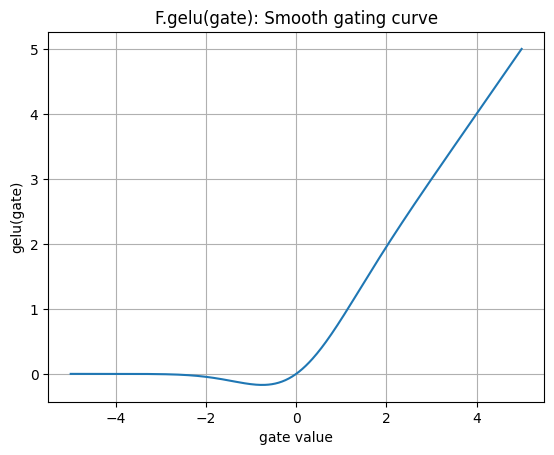

In [21]:
##### Demo: F.gelu(gate) 작동원리 이해하기 ! #####

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Discrete examples for intuition
gate = torch.tensor([-4.0, -2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 4.0]).view(1, -1)
gelu_gate = F.gelu(gate)

# We'll test gating on two example "x" vectors:
x_const = torch.ones_like(gate)           # all ones → output equals gelu(gate)
x_rand  = torch.linspace(-1.0, 1.0, gate.numel()).view(1, -1)  # a simple ramp from -1 to 1

out_const = x_const * gelu_gate
out_rand  = x_rand * gelu_gate

# Put into a small dataframe for inspection
df = pd.DataFrame({
    "gate": gate.flatten().numpy(),
    "gelu(gate)": gelu_gate.flatten().numpy(),
    "x_const=1": x_const.flatten().numpy(),
    "x_const * gelu(gate)": out_const.flatten().numpy(),
    "x_rand (−1→1)": x_rand.flatten().numpy(),
    "x_rand * gelu(gate)": out_rand.flatten().numpy(),
})


# 2) Continuous curve for gelu
g = torch.linspace(-5, 5, 400)
gelu_vals = F.gelu(g)

plt.figure()
plt.plot(g.numpy(), gelu_vals.numpy())
plt.title("F.gelu(gate): Smooth gating curve")
plt.xlabel("gate value")
plt.ylabel("gelu(gate)")
plt.grid(True)
plt.show()


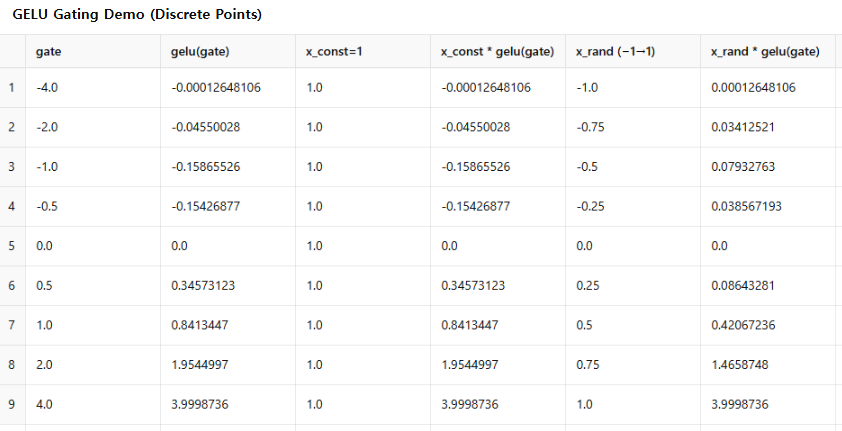

In [23]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class SwitchSequential(nn.Sequential):
    # for layer in self:가 가능한 이유는, SwitchSequential이 nn.Sequential을 상속해서 자기 안에 들어있는 모듈들을 순회할 수 있기 때문이야.
    # (즉, self는 레이어 리스트 컨테이너)
    
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

# UNET

In [25]:
# 입력 latent   (입력은 latent라서 해상도 기준을 h=H/8, w=W/8로 둘게요.)
# (B, 4, h, w)
#     │
#     ▼
# [Conv 3x3: 4→320]
#     │
#     ▼
# ╔══════════════════════ 인코더(다운 경로) ══════════════════════╗
# │ Res(320→320) → Attn(8×40)                                     │  ┐  Stage A (해상도 h×w, 채널 320)
# │ Res(320→320) → Attn(8×40)                                     │  ┘  (두 블록)
# │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ 해상도 1/2 → (h/2, w/2)
# │ Res(320→640)  → Attn(8×80)                                    │  ┐  Stage B (h/2×w/2, 채널 640)
# │ Res(640→640)  → Attn(8×80)                                    │  ┘  (두 블록)
# │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ (h/4, w/4)
# │ Res(640→1280) → Attn(8×160)                                   │  ┐  Stage C (h/4×w/4, 채널 1280)
# │ Res(1280→1280)→ Attn(8×160)                                   │  ┘  (두 블록)
# │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ (h/8, w/8)
# │ Res(1280→1280)                                                │  ┐  Stage D (h/8×w/8, 채널 1280)
# │ Res(1280→1280)                                                │  ┘  (두 블록)
# ╚════════════════════════════════════════════════════════════════╝

#                       ▼
#                 ┌───────────┐
#                 │ Bottleneck│    (h/8×w/8, 채널 1280)
#                 │ Res → Attn(8×160) → Res
#                 └───────────┘
#                       ▼

# ╔══════════════════════ 디코더(업 경로) ══════════════════════════════════════════╗
# │ ※ 각 단계에서 인코더의 동일 해상도 출력과 concat 후 처리                           │
# │ (채널은 concat 때문에 ↑ 된 뒤 Res로 정리)                                         │
# │                                                                                │
# │ 1) Stage D↔D:                                                                  │
# │    Concat: (1280 from up) + (1280 from enc) → 2560                             │
# │    Res(2560→1280)                                                              │
# │    Concat: (1280) + (1280 enc) → 2560 → Res(2560→1280)                         │
# │    Concat: (1280) + (1280 enc) → 2560 → Res(2560→1280) → Upsample(×2)          │
# │                                                                                │
# │ 2) Stage C↔C:  (해상도 (h/4, w/4), 채널 1280)                                   │
# │    Concat → 2560 → Res(2560→1280) → Attn(8×160)                                │
# │    Concat → 2560 → Res(2560→1280) → Attn(8×160)                                │
# │    Concat(1920)* → Res(1920→1280) → Attn(8×160) → Upsample(×2)                 │
# │       *이 줄은 이전 경로 채널이 640일 때 concat 합이 1920으로 설계된 자리           │
# │                                                                                │
# │ 3) Stage B↔B:  (해상도 (h/2, w/2), 채널 640)                                    │
# │    Concat → 1920 → Res(1920→640) → Attn(8×80)                                  │
# │    Concat → 1280 → Res(1280→640) → Attn(8×80)                                  │
# │    Concat → 960  → Res(960→640)  → Attn(8×80) → Upsample(×2)                   │
# │                                                                                │
# │ 4) Stage A↔A:  (해상도 (h, w), 채널 320)                                        │
# │    Concat → 960 → Res(960→320) → Attn(8×40)                                    │
# │    Concat → 640 → Res(640→320) → Attn(8×40)                                    │
# │    Concat → 640 → Res(640→320) → Attn(8×40)                                    │
# ╚═══════════════════════════════════════════════════════════════════════════════╝

# 출력: (B, 320, h, w)  ──(후단 헤드가 이어져 4ch 노이즈 예측 등으로 매핑)

### 이미지해상도 사이즈 변화
# 시작: VAE Enc → latent 크기 = (H/8, W/8), 채널 4

# U-Net 인코더(다운):
#     (H/8, W/8) → (H/16, W/16) → (H/32, W/32) → (H/64, W/64)
#     즉 /2를 3번 더 해서 원본 대비 H/64까지 내려감

# U-Net 보틀넥: (H/64, W/64) 유지

# U-Net 디코더(업):
#     다시 (H/32, W/32) → (H/16, W/16) → (H/8, W/8) 로 복구
#     출력: U-Net의 최종 출력도 (H/8, W/8) (채널 4의 노이즈 예측 등)

# 마지막: VAE Dec가 (H/8, W/8) latent를 H×W 이미지로 업샘플하여 복원

In [26]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

            # │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ 해상도 1/2 → (h/2, w/2)
            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),

            # │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ 해상도 1/2 → (h/4, w/4)
            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(640,  1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

            # │ ──────────────────────────────── Down: Conv(stride=2) ────────│      ↓ 해상도 1/2 → (h/8, w/8)
            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
 
        ])

        ## U-Net의 가장 낮은 해상도(H/64) 지점에서 전역 문맥을 강하게 섞어 디코더로 넘기기 전에 특징을 정제하는 “심장부”예요.
        ## 모양은 그대로(채널·해상도 유지)지만 의미는 가장 많이 바뀌는 구간
        self.bottleneck = SwitchSequential(
            UNET_ResidualBlock(1280, 1280),
            UNET_AttentionBlock(8, 160),    # 컨텍스트 집약: 인코더에서 내려오며 모은 정보를 전역적으로 재배치 → 이후 업샘플에서 디테일 복원에 도움.
            UNET_ResidualBlock(1280, 1280),
        )

        ## 스킵 채널에 따른 변화
        # H/32 구간 예: 현재 x가 1280인데, 스킵은 1280 → 1280+1280=2560
        # H/16 구간 예: 현재 x가 1280인데, 스킵은 640 → 1280+640=1920
        # H/8 구간 예: 현재 x가 640인데, 스킵은 320 → 640+320=960
        self.decoders = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])

    def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim) 
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)   # x = (B, 채널, h, w) / 채널 = (320, 640, 1280)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x
        
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # x: (Batch_Size, 320, Height / 8, Width / 8)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = self.groupnorm(x)
        
        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = F.silu(x)
        
        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.conv(x)
        
        # (Batch_Size, 4, Height / 8, Width / 8) 
        return x

# Diffusion

In [28]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)

    def forward(self, latent, context, time):
        # latent: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 320)

        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)
        
        # (Batch, 4, Height / 8, Width / 8) -> (Batch, 320, Height / 8, Width / 8)
        output = self.unet(latent, context, time)
        
        # (Batch, 320, Height / 8, Width / 8) -> (Batch, 4, Height / 8, Width / 8)
        output = self.final(output)
        
        # (Batch, 4, Height / 8, Width / 8)
        return output
        
### Diffusion의 마지막 출력은 4채널이고, 이건 **RGB 이미지가 아니라 “latent 공간(4채널)에서의 노이즈 예측”** 
# **“텍스트 → 이미지”**는 Stable Diffusion 파이프라인이 텍스트 조건을 준 채로 latent(4채널) 노이즈를 점점 정리한 다음,
# VAE 디코더로 RGB로 복원하는 과정이야.

## *** "VAE 디코더가 Loss에 참여하는가? 원본이미지와 비교하는 학습을 진행하는가?" ***
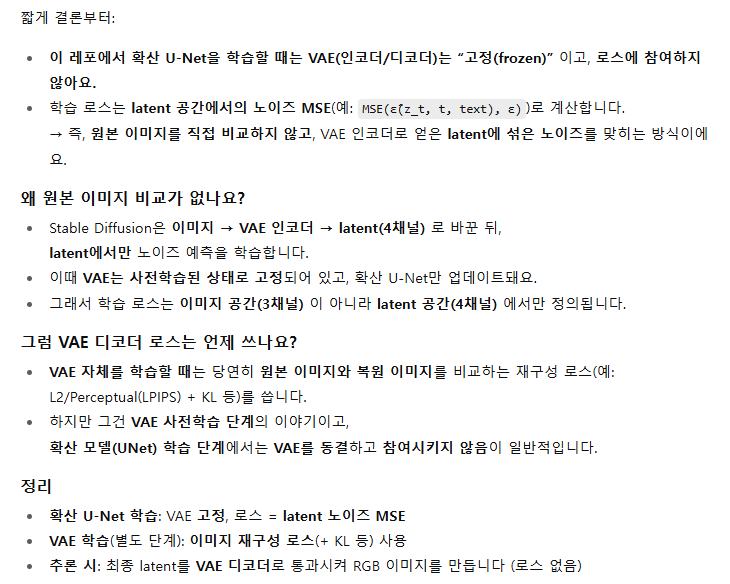

# DDPM Sampler

In [31]:
import math
import torch
import numpy as np

beta_start = 0.01
beta_end = 0.09
num_training_steps = 20
beta = torch.linspace(math.sqrt(beta_start), math.sqrt(beta_end), num_training_steps)**2
beta_np = beta.detach().numpy()

print(math.sqrt(beta_start))
print(math.sqrt(beta_end))
print(torch.linspace(math.sqrt(beta_start), math.sqrt(beta_end), num_training_steps))
print(torch.linspace(math.sqrt(beta_start), math.sqrt(beta_end), num_training_steps)**2)
print("*****" * 10)

diff = []
for i in range(len(beta_np)-1):
    diff.append(beta_np[i+1] - beta_np[i])
    
# diff = np.diff(beta_np) 간결 코드 
print(diff)
### 초반엔 천천히 증가, 후반엔 더 크게 증가(볼록하게 증가)

0.1
0.3
tensor([0.1000, 0.1105, 0.1211, 0.1316, 0.1421, 0.1526, 0.1632, 0.1737, 0.1842,
        0.1947, 0.2053, 0.2158, 0.2263, 0.2368, 0.2474, 0.2579, 0.2684, 0.2789,
        0.2895, 0.3000])
tensor([0.0100, 0.0122, 0.0147, 0.0173, 0.0202, 0.0233, 0.0266, 0.0302, 0.0339,
        0.0379, 0.0421, 0.0466, 0.0512, 0.0561, 0.0612, 0.0665, 0.0720, 0.0778,
        0.0838, 0.0900])
**************************************************
[0.0022160662, 0.0024376744, 0.002659279, 0.0028808862, 0.0031024925, 0.0033241045, 0.003545707, 0.0037673134, 0.003988918, 0.0042105243, 0.004432127, 0.004653748, 0.0048753433, 0.0050969534, 0.0053185634, 0.0055401623, 0.00576178, 0.0059833676, 0.0062049925]


In [32]:
num_inference_steps=4
timesteps = np.arange(0, num_training_steps)[::-1].copy()
step_ratio = num_training_steps // num_inference_steps
print(timesteps)
print(step_ratio)
print(np.arange(0, num_inference_steps))
print(np.arange(0, num_inference_steps) * step_ratio)

timesteps_ratio = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy()
prev_t = timesteps_ratio - step_ratio
print(timesteps_ratio)
print(timesteps_ratio - step_ratio)

[19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
5
[0 1 2 3]
[ 0  5 10 15]
[15 10  5  0]
[10  5  0 -5]


In [33]:
one = 1.0
alphas = 1.0 - beta_np
print(f"alphas : \n{alphas}")
print("*****"*10)

alphas_cumprod = np.cumprod(alphas)
print(f"alphas_cumprod : \n{alphas_cumprod}")
print("*****"*10)

alpha_prod_t = alphas_cumprod[timesteps_ratio]
print(f"alpha_prod_t : \n{alpha_prod_t}")
print("*****"*10)

### alpha_prod_t_prev = alphas_cumprod[prev_t] if prev_t >= 0 else one 이 코드를 아래와 같이 바꿈 
mask = prev_t >=0
alpha_prod_t_prev = np.where(
    mask,
    alphas_cumprod[prev_t],
    np.full(prev_t.shape, one, dtype=alphas_cumprod.dtype),
)
print(f"alpha_prod_t_prev : \n{alpha_prod_t_prev}")
print("*****"*10)

current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev
print(f"current_beta_t : \n{current_beta_t}")
print("*****"*10)

variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
print(f"variance : \n{variance}")
print("*****"*10)
# variance는 역확산 한 스텝에서 넣어줄 랜덤성의 분산:
# 샘플링에서 𝑥𝑡−1을 뽑을 때 가우시안 노이즈를 추가하는데, 그때 쓰는 분산이 바로 이 값.

print(1 - alpha_prod_t)
print((1 - alpha_prod_t) * current_beta_t)
# (1 - alpha_prod_t) * current_beta_t 이 부분은 누적 노이즈 크기에 이번 스텝에서 더해지는 노이즈 분산을 곱한 산술적 곱입니다.
# 이번 단계 𝑡에서 𝑥𝑡−1 → 𝑥𝑡 로 갈 때 추가되는 노이즈의 분산

alphas : 
[0.99       0.9877839  0.98534626 0.982687   0.97980607 0.9767036
 0.9733795  0.9698338  0.9660665  0.96207756 0.957867   0.9534349
 0.94878113 0.94390583 0.93880886 0.9334903  0.92795014 0.92218834
 0.916205   0.90999997]
**************************************************
alphas_cumprod : 
[0.99       0.9779061  0.96357614 0.94689375 0.9277722  0.90615845
 0.88203603 0.85542834 0.82640064 0.7950615  0.76156324 0.726101
 0.6889109  0.650267   0.61047643 0.5698738  0.5288145  0.48766655
 0.44680253 0.40659028]
**************************************************
alpha_prod_t : 
[0.5698738  0.76156324 0.90615845 0.99      ]
**************************************************
alpha_prod_t_prev : 
[0.76156324 0.90615845 0.99       1.        ]
**************************************************
current_beta_t : 
[0.25170523 0.15956944 0.08468843 0.00999999]
**************************************************
variance : 
[0.13953064 0.06280174 0.00902461 0.        ]
********************

## *****************************************
## *** "variance의 의미는??" ***
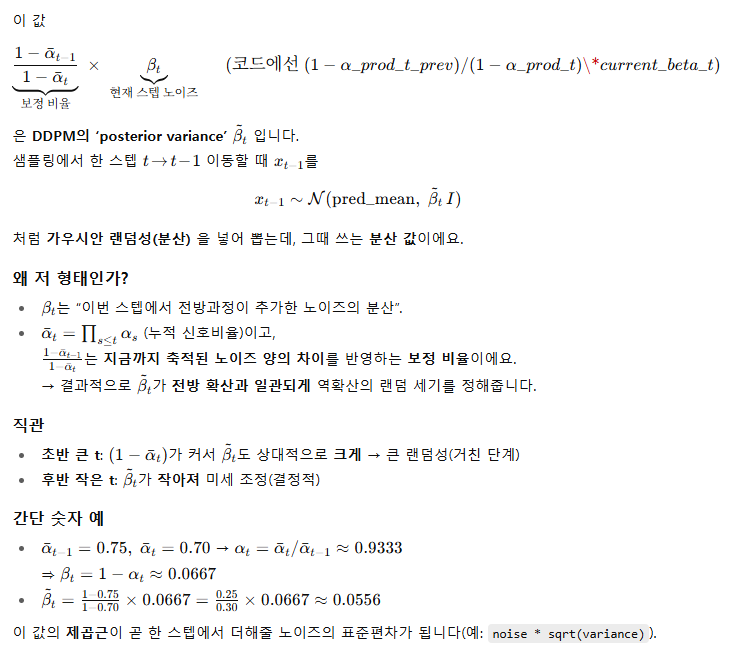

In [35]:
import torch
import numpy as np

### LoRA로 U-Net을 학습할 때 DDPMSampler는 안 씁니다.
### 샘플러는 추론(역확산) 용이고, 학습(전방 확산) 에서는 직접 공식을 써서 𝑧𝑡를 만듭니다.
### LoRA 학습 = 전방 확산 공식 + MSE(ε̂, ε)
class DDPMSampler:
    def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start: float=0.00085, beta_end: float=0.0120):
        # beta_start=0.00085, beta_end=0.0120 는 전방 확산에서 매 스텝에 추가하는 가우시안 노이즈의 분산(βₜ) 범위를 정하는 숫자
        # 베타 스케줄을 “제곱근 공간에서 선형으로” 만든 다음 다시 제곱해서 원래 공간으로 돌려놓는 거예요.
        # 즉, √β를 등차수열로 만들고 마지막에 ^2 해서 β를 얻는 방식.
        # 그래서 초반엔 천천히 증가, 후반엔 더 크게 증가(볼록하게 증가)합니다.
        self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_training_steps, dtype=torch.float32)**2
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)

        self.generator = generator

        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())
            # 샘플링(추론)에서는 “역방향”으로 진행하기 때문에 숫자를 거꾸로 저장
            # 학습(전방 과정): 깨끗한 x₀에 노이즈를 점점 더해서 x₁, x₂, …, x_T로 t=0→T 방향으로 진행.
            # 샘플링(역방 과정): 순수 노이즈 x_T에서 시작해 U-Net이 예측한 노이즈를 이용해 x_T → x_{T-1} → … → x_0로 t=T→0 방향으로 되돌아감.
        
    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps   # = 1000 // 50 = 20
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    ## **“이전 스텝 인덱스(prev_t)를 계산”**
    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t
            # 숫자 예시:
                # 학습 스텝: 0..999
                # 추론 스텝(역순): 980, 960, 940, …, 0 (간격 20)
                # 지금 timestep = 980이면
                # prev_t = 980 - 20 = 960
                # 다음엔 timestep = 960일 때
                # prev_t = 960 - 20 = 940
                # … 이런 식으로 이전 인퍼런스 스텝의 원본(학습) 인덱스를 가리킴.
        
    # variance는 역확산 한 스텝에서 넣어줄 랜덤성의 분산:
    # 샘플링에서 𝑥𝑡−1(아래 코드에서 alpha_prod_t_prev)을 뽑을 때 가우시안 노이즈를 추가하는데, 그때 쓰는 분산이 바로 이 값.
    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
            #      |----------------- 보정 비율 ---------------| x 현재 스텝 노이즈 
            #      지금까지 축적된 노이즈 양의 차이를 반영하는 보정 비율
            # 현재까지 섞인 총노이즈 비중(분모) 대비, 직전 단계까지의 총노이즈 비중(분자)을 비교해 𝛽𝑡를 줄여줍니다.(아래 예시 참고)
        
        variance = torch.clamp(variance, min=1e-20)

        return variance
# 예시:
# 𝛼ˉ𝑡−1 = 0.75               # (alpha_prod_t_prev)
# 𝛼ˉ𝑡 = 0.60                 # (alpha_prod_t)
# 먼저 𝛼𝑡 = 𝛼ˉ𝑡 / 𝛼ˉ𝑡−1 = 0.60/0.75 = 0.8     # (alpha_prod_t) / (alpha_prod_t_prev)
# 따라서 𝛽𝑡 = 1−𝛼𝑡 = 1−0.8 = 0.2
# 보정계수:
#     (1 − 𝛼ˉ𝑡−1) / (1 − 𝛼ˉ𝑡) = (1−0.75) / (1−0.60) = 0.25/0.40 = 0.625
# 사후분산:
# 𝛽ˉ𝑡 = 0.625 × 0.2 = 0.125
# 해석: 원래 이번 스텝의 분산 𝛽𝑡=0.2를 “우리가 이미 알고 있는 𝑥𝑡정보” 때문에 0.125로 줄여써요. (정보가 늘었으니 분산이 작아짐)

    def set_strength(self, strength=1):
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
            # 예시) strength = 0.8 :
            # start_step = 50 - int(50*0.8) = 50 - 40 = 10
            # 앞 10스텝 건너뜀 → 40스텝만 수행
        
        self.timesteps = self.timesteps[start_step:]
            # self.timesteps는 역순(큰 t → 작은 t) 의 길이 num_inference_steps 배열.
            # strength에 따라 앞쪽의 일부 스텝을 건너뛰고(= 덜 noisy한 지점에서 시작) 남은 스텝만 수행.
        
        self.start_step = start_step


    def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
        # model_output 모양은 (batch_or_2batch, 4, 64, 64),
            # do_cfg = False (기본 배치 1이라고 가정):
                # (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH) = (1, 4, 64, 64)
            # do_cfg = True (CFG 위해 cond/uncond 배치 2배):
                # (2, 4, LATENTS_HEIGHT, LATENTS_WIDTH) = (2, 4, 64, 64)
                # 첫 절반: cond(프롬프트) 결과
                # 둘째 절반: uncond(빈 프롬프트) 결과
        # model_output 내용은 latent 4채널 노이즈 예측치입니다.
        
        t = timestep
        prev_t = self._get_previous_timestep(t)

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t


        ##### DDPM posterior mean 식:
        #              coeff_x0 = ( √(ᾱ_{t-1}) · β_t ) / ( 1 - ᾱ_t )
        #              coeff_xt = ( √(α_t) · (1 - ᾱ_{t-1}) ) / ( 1 - ᾱ_t )
        
        #                  ┌──────────────────────┐
        #                  │     \hat{x}_0        │  (pred_original_sample)
        #                  └──────────┬───────────┘
        #                             │  × coeff_x0
        #                             ▼
        #                          (가중분)
        
        # x_t (latents) ────────────┐
        #                           │  × coeff_xt
        #                           ▼
        #                        (가중분)
        
        #                  ┌──────────────────────┐
        #                  │       μ_t            │  = coeff_x0·\hat{x}_0  +  coeff_xt·x_t
        #                  └──────────────────────┘
        ##### 즉, “지금 본 것(𝑥𝑡)”과 “노이즈를 뺀 원본 추정(𝑥^0)”을 이론적으로 정해진 비율로 블렌딩해서
        ##### 다음 스텝 평균 pred_prev_sample(= 𝜇𝑡)을 만든다고 보면 돼.
        
        
        # 2. 노이즈가 섞인 현재 latent로부터 원본 latent를 추정
        # 현재 𝑡에서 본 값과 예측한 노이즈를 이용한 원본(latent) 추정치
        pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 3. 위 원본 추정치 계수(아래 그림에서는 "이 계수" 해당)
        # 이번 스텝 평균을 만들 때 그 원본 추정치를 얼마나 신뢰할지를 나타내는 비율.
        # 값이 클수록 𝑥^0 쪽을 더 많이 반영, 작을수록 현재 𝑥𝑡쪽 비중이 큼.
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t  # 위 그림에서 coeff_x0 해당 

        # 4. 시점 t에서 노이즈가 섞인 latent 상태 xt에 대한 계수(아래 그림에서는 "다른 계수" 해당)
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t          # 위 그림에서 coeff_xt 해당 
        
        # 5. previous sample 평균의 의미
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

        # 6. Add noise 평균에 분산을 더함 
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
            variance = (self._get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample  
            ### 반환값:
            # 사이즈 : 입력값 latents와 동일 (B, 4, LATENTS_HEIGHT, LATENTS_WIDTH) — 예제에선 보통 (1, 4, 64, 64)
                # 동일한 이유:
                    # pred_prev_sample = a * pred_original_sample + b * latents (+ noise_term)
                    # 여기서 a, b와 variance는 스칼라(또는 (B,1,1,1)로 브로드캐스트)라서,
                    # pred_original_sample과 latents(둘 다 (B,4,h,w))를 가중합/노이즈추가해도 모양은 그대로야.

    def add_noise(
        self,
        original_samples: torch.FloatTensor,     # 노이즈 안섞인 latents 
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()

        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            # 예를 들어 (B, C, H, W) 4차원이라면 **len(original_samples.shape) == 4**가 나옴 
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)
                # sqrt_alpha_prod는 타임스텝별 스칼라(또는 1D 벡터) 이고,
                # original_samples는 보통 4D 텐서(B, C, H, W)라서 차원 수(rank) 가 다를 수 있어.
                # 그래서 (B,) → (B,1) → (B,1,1) → (B,1,1,1) 식으로 뒤에서 1을 계속 붙여 곱셈이 가능한 모양으로 맞추는 거야.
                    # 한 눈 예시:
                        # original_samples.shape = (2, 4, 64, 64)
                        # timesteps.shape = (2,)
                        # alphas_cumprod[timesteps].shape = (2,)
                        # while 루프 후: sqrt_alpha_prod.shape = (2, 1, 1, 1)
                        # 곱셈:
                        # sqrt_one_minus_alpha_prod * original_samples → (2,1,1,1) * (2,4,64,64) = (2,4,64,64)로 브로드캐스트 OK

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise

        return noisy_samples
        

## ** (중요) 공식 이해해보기 **
##  공식 1. "DDPM posterior mean 식"
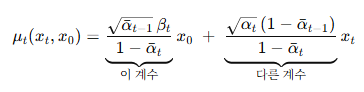
## **************************************
### 공식 2. "pred_original_sample = (latents - sqrt(beta_prod_t) * model_output) / sqrt(alpha_prod_t)" 
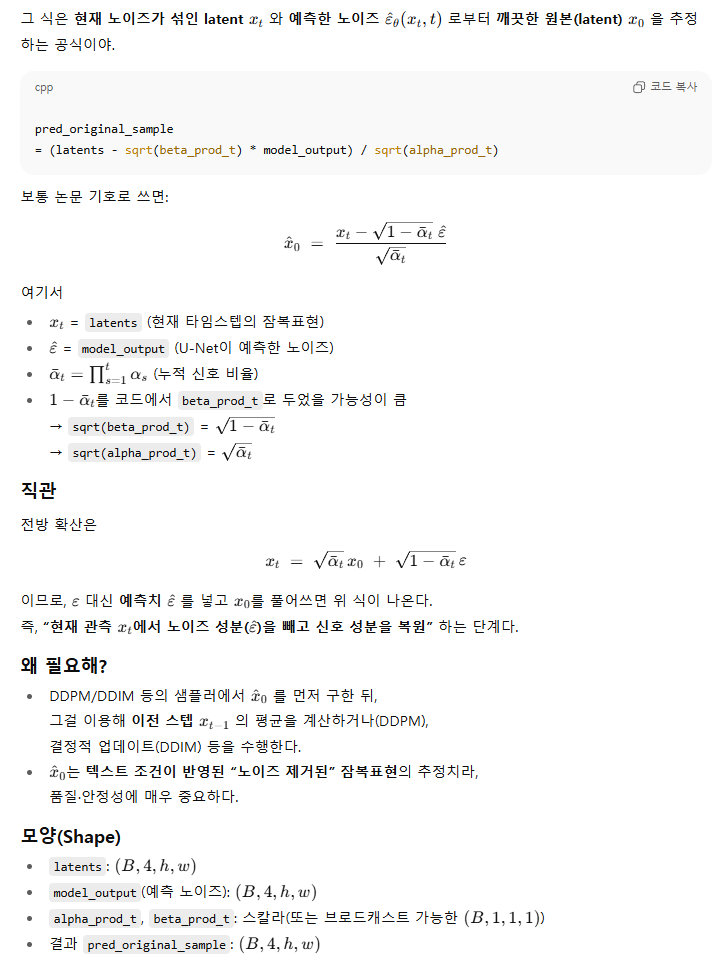

In [37]:
##### add_noise 예시 #####

import torch

### 1) 배치 2개, 4D 텐서 예시 (브로드캐스팅 확인용)
# toy latents: B=2, C=1, H=2, W=2  (값을 작게 만들어 직관적)
original_samples = torch.tensor(
    [[[[ 0.0,  0.5],
       [ 1.0, -0.5]]],      # 샘플 #1

     [[[ 0.2, -0.2],
       [ 0.8,  1.2]]]]      # 샘플 #2
, dtype=torch.float32)

print(f"alphas_cumprod : \n {alphas_cumprod}")
print(f"timesteps: \n {timesteps}")
print(f"timesteps_ratio: \n {timesteps_ratio}")
print(f"alpha_prod_t: \n {alpha_prod_t}")

sqrt_alpha_prod = alphas_cumprod[timesteps_ratio] ** 0.5
print(f"sqrt_alpha_prod: \n {sqrt_alpha_prod}")
sqrt_alpha_prod = sqrt_alpha_prod.flatten()
print(f"sqrt_alpha_prod_flatten: \n {sqrt_alpha_prod}")   # (변화 없음)

alphas_cumprod : 
 [0.99       0.9779061  0.96357614 0.94689375 0.9277722  0.90615845
 0.88203603 0.85542834 0.82640064 0.7950615  0.76156324 0.726101
 0.6889109  0.650267   0.61047643 0.5698738  0.5288145  0.48766655
 0.44680253 0.40659028]
timesteps: 
 [19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
timesteps_ratio: 
 [15 10  5  0]
alpha_prod_t: 
 [0.5698738  0.76156324 0.90615845 0.99      ]
sqrt_alpha_prod: 
 [0.75489986 0.8726759  0.95192355 0.9949874 ]
sqrt_alpha_prod_flatten: 
 [0.75489986 0.8726759  0.95192355 0.9949874 ]


# pipeline

In [39]:
import torch
import numpy as np
from tqdm import tqdm

WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generate(
    prompt,
    uncond_prompt=None,
    input_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("strength must be between 0 and 1")

        if idle_device:
            to_idle = lambda x: x.to(idle_device)
        else:
            to_idle = lambda x: x

        generator = torch.Generator(device=device)   # DDPMSampler 클래스 매개변수로서 torch.randn에 매개변수로 사용하여 noise 생성
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        clip = models["clip"]
        clip.to(device)

        if do_cfg:
            # tokenizer는 clip tokenizer
            cond_tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            cond_context = clip(cond_tokens)

            uncond_tokens = tokenizer.batch_encode_plus(
                [uncond_prompt], padding="max_length", max_length=77
            ).input_ids
            uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            uncond_context = clip(uncond_tokens)
            # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (2 * Batch_Size, Seq_Len, Dim)
            context = torch.cat([cond_context, uncond_context])
        else:
            tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            tokens = torch.tensor(tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            context = clip(tokens)
            
        to_idle(clip)

        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. ")

        latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        if input_image:
            encoder = models["encoder"]
            encoder.to(device)

            ## 이미지 전처리
            input_image_tensor = input_image.resize((WIDTH, HEIGHT))
            # (Height, Width, Channel)
            input_image_tensor = np.array(input_image_tensor)
            input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
            input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
            input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size, Channel, Height, Width)
            input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)
            
            ## letents 생성
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = encoder(input_image_tensor, encoder_noise)

            sampler.set_strength(strength=strength)
            latents = sampler.add_noise(latents, sampler.timesteps[0])
                ### 왜 “두 번” 노이즈가 필요하나? 용도가 다르다. 
                # VAE 노이즈:
                #     VAE 인코더는 입력 이미지를 latent 평균 + 표준편차 × N(0,1) 로 샘플링합니다.
                #     즉, 이미지→latent로 바꾸는 확률적 샘플링 단계의 노이즈.
                #     같은 이미지를 넣어도 매번 살짝 다른 latent가 나올 수 있음.
                # 샘플러 노이즈:
                #     이 노이즈는 프롬프트에 맞게 얼마나 멀리 보낼지(원본에서 얼마나 벗어날지)를 정하는 핵심입니다.
                #     img2img는 원본 이미지의 latent 𝑥0 를 바로 쓰지 않고,
                #     strength에 맞는 시작 시점 𝑡𝑠의 𝑥𝑡𝑠로 “앞방향 노이즈”를 추가해 둔 뒤,
                #     거기서부터 역확산을 시작합니다.

                ### sampler.timesteps[0]는 샘플러가 사용할 타임스텝 배열에서 “첫 번째 스텝(시작 시점 t_s)” 을 뜻해.
                # set_inference_timesteps(n)를 부르면, 샘플러는 학습 스텝(예: 1000)을 n개로 등간격 다운샘플해서 내림차순 배열을 만든다.
                # 예: n=50이면 대략
                # [980, 960, 940, 920, 900, …, 0]
                # set_strength(strength)를 부르면 앞쪽 일부 스텝을 건너뛰어 시작점을 뒤로 미룬다.
                # 예: strength=0.8이면 start_step = 50 - int(50*0.8) = 10 →
                # 타임스텝 배열을 self.timesteps = self.timesteps[10:]로 잘라서
                # [780, 760, 740, …, 0] 가 된다.
                # 따라서 sampler.timesteps[0] = 현재 설정(특히 strength 반영) 이후의 시작 타임스텝 𝑡𝑠 (예시에 따르면 780)

            to_idle(encoder)
        else:
            latents = torch.randn(latents_shape, generator=generator, device=device)

        diffusion = models["diffusion"]
        diffusion.to(device)

        timesteps = tqdm(sampler.timesteps)
        for i, timestep in enumerate(timesteps):
            #(1, 320)
            time_embedding = get_time_embedding(timestep).to(device)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            model_input = latents

            if do_cfg:
                # (Batch_Size, 4, Latents_Height, Latents_Width) -> (2 * Batch_Size, 4, Latents_Height, Latents_Width)
                model_input = model_input.repeat(2, 1, 1, 1)

            model_output = diffusion(model_input, context, time_embedding)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond
                    # 위 코드조각은 **CFG(Classifier-Free Guidance)**로, “프롬프트의 영향”을 키워서 최종 노이즈 예측을 만드는 공식이야.
                        # output_uncond (ε̂_uncond): 프롬프트 없이(빈 문장) 예측한 노이즈
                        # output_cond (ε̂_cond): 프롬프트를 넣고 예측한 노이즈
                        # (ε̂_cond − ε̂_uncond): 프롬프트가 끌어당기는 “방향” (둘의 차이)
                        # cfg_scale: 그 방향을 얼마나 세게 밀지를 정하는 노브(보통 5~8)

            latents = sampler.step(timestep, latents, model_output)

        to_idle(diffusion)

        decoder = models["decoder"]
        decoder.to(device)
        
        # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 3, Height, Width)
        images = decoder(latents)
        to_idle(decoder)

        images = rescale(images, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()

        return images[0]

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x
    
### 한 줄 흐름:
# 다양한 주파수(freqs) 벡터 만들기 → 길이 160
# 스칼라 timestep을 각 주파수와 곱하기 → 길이 160의 각도 벡터
# cos, sin 둘 다 계산해서 붙이기 → 길이 320
def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
        # torch.arange(0,160)/160 → 0, 1/160, 2/160, …, 159/160
        # 10000^(-k) 형태로 지수적으로 줄어드는 주파수를 만듭니다.
    
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
        # timestep(스칼라)을 (1,1)로 만들고, freqs(1,160)와 브로드캐스트 곱
        # 결과 x[0, i] = timestep * freqs[i] 는 각 주파수 대역에서의 각도(angle)
    
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)
        # (이 값은 뒤에서 TimeEmbedding(320→1280) MLP의 입력 차원으로 쓰여요)
        ### 직관 미니 예시:
            # 만약 3개의 주파수만 쓴다면(단순화):
            # freqs = [1.0, 0.1, 0.01]
            # t=780 → 각도 x = [780, 78, 7.8]
            # cos(x)=[cos(780), cos(78), cos(7.8)]
            # sin(x)=[sin(780), sin(78), sin(7.8)]
            # 붙이면 길이 6짜리 벡터. 실제 코드는 이걸 160개 주파수로 확장한 버전.



# model loader

In [41]:
import model_converter

def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

    encoder = VAE_Encoder().to(device)
    encoder.load_state_dict(state_dict['encoder'], strict=True)

    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(state_dict['decoder'], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict['diffusion'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

# demo

In [43]:
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cuda"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

C:\Users\USER\anaconda3\envs\roboflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


C:\Users\USER\AppData\Local\Temp\ipykernel_19336\2074775052.py:13: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


In [44]:
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file, DEVICE)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:05<00:00,  7.59it/s]


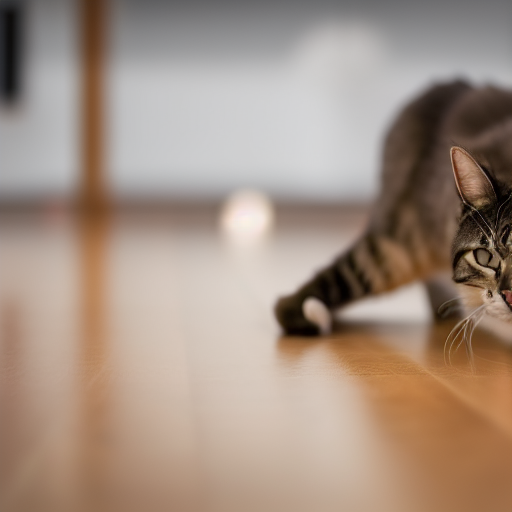

In [45]:
## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# input_image = None
# Comment to disable image to image
image_path = "../images/sample_dog.jpg"
input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [46]:
models

{'clip': CLIP(
   (embedding): CLIPEmbedding(
     (token_embedding): Embedding(49408, 768)
   )
   (layers): ModuleList(
     (0-11): 12 x CLIPLayer(
       (layernorm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (attention): SelfAttention(
         (in_proj): Linear(in_features=768, out_features=2304, bias=True)
         (out_proj): Linear(in_features=768, out_features=768, bias=True)
       )
       (layernorm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (linear_1): Linear(in_features=768, out_features=3072, bias=True)
       (linear_2): Linear(in_features=3072, out_features=768, bias=True)
     )
   )
   (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
 ),
 'encoder': VAE_Encoder(
   (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): VAE_ResidualBlock(
     (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
     (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

# LORA Train 
- LoRA는 선형층 y = Wx에 저랭크 보정을 추가해서
- y = W x  +  s · (B @ A) x          # A: (r × in), B: (out × r), s = alpha / r
- 즉, 각 타깃 Linear 모듈에 (A, B, alpha, scaling) 파라미터가 추가되고,
- requires_grad=True가 LoRA 파라미터에만 켜진다(기존 W는 freeze)
- 아래는 LORA를 붙일수 있는 어텐션 선형층
    - SelfAttention:
        - in_proj: Linear(d, 3d) ← q/k/v 한 번에 뽑는 fused qkv
        - out_proj: Linear(d, d)
    - CrossAttention:
        - q_proj: Linear(d, d)
        - k_proj: Linear(768, d) ← 텍스트 임베딩에서 옴
        - v_proj: Linear(768, d)
        - out_proj: Linear(d, d)
    - CLIP 텍스트 인코더(네 CLIP):
        - 각 layer의 attention.in_proj: Linear(768, 2304) (fused qkv)
        - attention.out_proj: Linear(768, 768)
    - 추가로 VAE_AttentionBlock(인코더 13번, 디코더 3번):
        - attention.in_proj: Linear(512, 1536)
        - attention.out_proj: Linear(512, 512)

## *** "일반 train 훈련과 Lora 훈련 차이점은?" ***
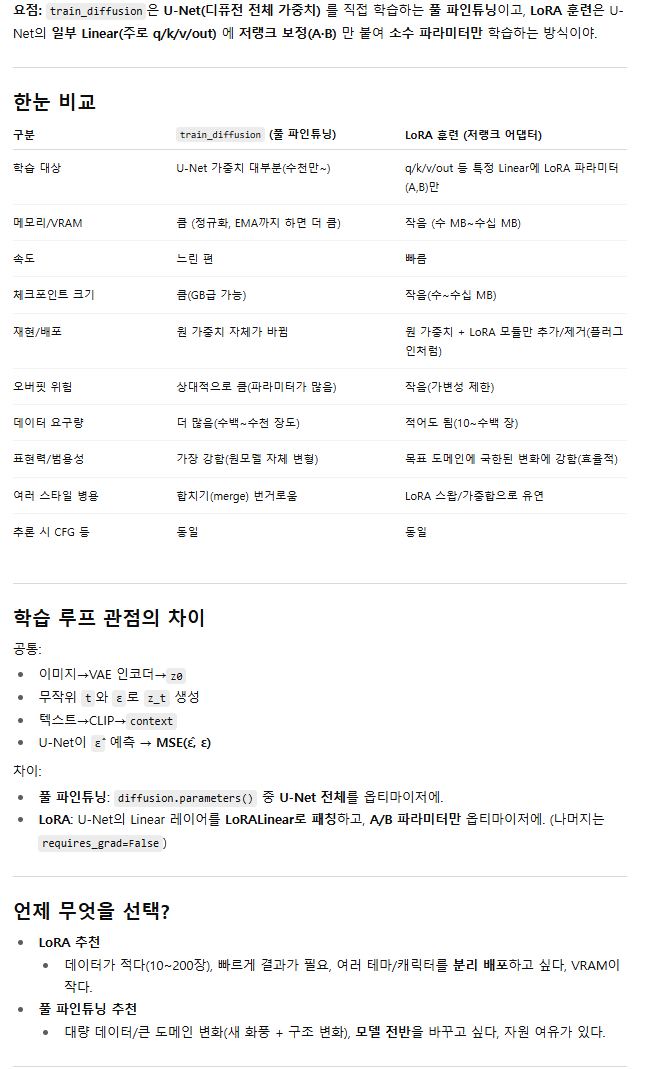

In [49]:
list(models["diffusion"].unet.named_children())

[('encoders',
  ModuleList(
    (0): SwitchSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x SwitchSequential(
      (0): UNET_ResidualBlock(
        (groupnorm_feature): GroupNorm(32, 320, eps=1e-05, affine=True)
        (conv_feature): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (linear_time): Linear(in_features=1280, out_features=320, bias=True)
        (groupnorm_merged): GroupNorm(32, 320, eps=1e-05, affine=True)
        (conv_merged): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (residual_layer): Identity()
      )
      (1): UNET_AttentionBlock(
        (groupnorm): GroupNorm(32, 320, eps=1e-06, affine=True)
        (conv_input): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
        (layernorm_1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (attention_1): SelfAttention(
          (in_proj): Linear(in_features=320, out_features=960, bi

In [50]:
import re
def is_attention_linear(name, sub):
    # name은 모듈의 바로 아래 attribute 이름 (예: "in_proj", "out_proj", "q_proj"...)
    print(f"name : \n {name}")
    print(f"sub: \n {sub}")
    return bool(re.match(r"(in_proj|out_proj|q_proj|k_proj|v_proj)$", name))

for name, sub in models["diffusion"].unet.named_modules():
    ok = is_attention_linear(name, sub)
    print(f" -> match? {ok}")

name : 
 
sub: 
 UNET(
  (encoders): ModuleList(
    (0): SwitchSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x SwitchSequential(
      (0): UNET_ResidualBlock(
        (groupnorm_feature): GroupNorm(32, 320, eps=1e-05, affine=True)
        (conv_feature): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (linear_time): Linear(in_features=1280, out_features=320, bias=True)
        (groupnorm_merged): GroupNorm(32, 320, eps=1e-05, affine=True)
        (conv_merged): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (residual_layer): Identity()
      )
      (1): UNET_AttentionBlock(
        (groupnorm): GroupNorm(32, 320, eps=1e-06, affine=True)
        (conv_input): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
        (layernorm_1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (attention_1): SelfAttention(
          (in_proj): Linear(in_features=320,

In [51]:
import re, torch.nn as nn

pat = re.compile(r"(in_proj|out_proj|q_proj|k_proj|v_proj)$")

hits = []
for full_name, sub in models["diffusion"].unet.named_modules():
    if isinstance(sub, nn.Linear):
        last = full_name.split(".")[-1]
        ok = bool(pat.match(last))
        if ok:
            hits.append((full_name, sub))

print(f"[UNet] matched Linear layers: {len(hits)}")
for n, (full_name, layer) in enumerate(hits[:10], 1):   # 앞 10개만 미리보기
    print(f"{n:02d}. {full_name} :: {layer}")

[UNet] matched Linear layers: 96
01. encoders.1.1.attention_1.in_proj :: Linear(in_features=320, out_features=960, bias=False)
02. encoders.1.1.attention_1.out_proj :: Linear(in_features=320, out_features=320, bias=True)
03. encoders.1.1.attention_2.q_proj :: Linear(in_features=320, out_features=320, bias=False)
04. encoders.1.1.attention_2.k_proj :: Linear(in_features=768, out_features=320, bias=False)
05. encoders.1.1.attention_2.v_proj :: Linear(in_features=768, out_features=320, bias=False)
06. encoders.1.1.attention_2.out_proj :: Linear(in_features=320, out_features=320, bias=True)
07. encoders.2.1.attention_1.in_proj :: Linear(in_features=320, out_features=960, bias=False)
08. encoders.2.1.attention_1.out_proj :: Linear(in_features=320, out_features=320, bias=True)
09. encoders.2.1.attention_2.q_proj :: Linear(in_features=320, out_features=320, bias=False)
10. encoders.2.1.attention_2.k_proj :: Linear(in_features=768, out_features=320, bias=False)


In [52]:
import re, torch.nn as nn, torch

# --- LoRA 래퍼 ---
class LoRALinear(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=8, dropout=0.0):
        super().__init__()
        self.in_features = base.in_features
        self.out_features = base.out_features
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        self.use_bias = base.bias is not None

        self.weight = nn.Parameter(base.weight.data.clone(), requires_grad=False)
            ### nn.Parameter가 뭐야?
            # 학습할 가중치를 뜻하는 특별한 Tensor야.
            # nn.Module 안에 self.xxx = nn.Parameter(tensor)로 넣으면,
            # model.parameters()에 자동 등록됨 → Optimizer가 이걸 업데이트 대상이라고 인식
            # model.state_dict()에 저장됨/load_state_dict()로 로드됨
            # model.to(device)나 .cuda() 호출 시 같이 이동함
            # 기본 requires_grad=True → 역전파로 gradient가 계산됨
        
        self.bias = None
        if self.use_bias:
            self.bias = nn.Parameter(base.bias.data.clone(), requires_grad=False)

        self.A = nn.Parameter(torch.zeros(r, self.in_features))    # (r × in)
        self.B = nn.Parameter(torch.zeros(self.out_features, r))   # (out × r)
            ### torch.zeros(r, self.in_features) 의미:
                # → 크기가 (r, in_features) 인 2차원 텐서를 만듭니다.
                # 즉,
                # 행(row) 개수 = r
                # 열(column) 개수 = self.in_features
                # 모든 원소 값 = 0
                # 예를 들어 r=8, in_features=320이면
                # torch.zeros(8, 320) → (8×320)짜리 전부 0으로 채워진 행렬을 만드는 거예요.
            ### LoRA에서 왜 이런 크기냐?
                # ΔW=B@A
                # A: (r × in_features)
                # → 입력 차원을 r차원으로 “압축”
                # B: (out_features × r)
                # → r차원을 다시 출력 차원으로 “복원”
            # LoRA는 원래 가중치 W를 **저랭크 분해( rank = r )**한 보정으로 근사해:
                # Weff=W+scaling⋅(B@A)
            # 그래서 학습 대상은 A, B 두 개뿐이야.
                # A: 입력 차원(in_features)을 r 차원으로 압축
                # B: r 차원을 출력(out_features)으로 복원
            ### 흐름 한 눈에:
                # forward에서
                    # y = x @ W^T + bias
                    # lora = (x → A → B)    # x @ A^T @ B^T
                    # out = y + scaling * lora
                # backward(역전파)에서
                    # A, B에만 grad가 생김(학습)
                    # W, bias는 requires_grad=False라 고정
            ### torch.zeros(...)로 초기화하는 이유는?
                # LoRA가 추가하는 보정은 ΔW = B @ A 이고
                # 출력은 y = x @ Wᵀ + scaling * (x @ Aᵀ @ Bᵀ)
                # 이때 B=0로 시작하면 ΔW = 0이라 초기 출력은 기존 모델과 100% 동일해져.
                # 즉, 학습 시작 시 기본 가중치 W를 망가뜨리지 않고 안정적으로 미세조정을 시작함.
        nn.init.kaiming_uniform_(self.A, a=5**0.5)
        nn.init.zeros_(self.B)
            # Kaiming 균등 초기화(uniform)로 self.A의 값을 채워요.
            # self.A의 각 값이 [-1/√fan_in, +1/√fan_in] 범위에서 균등분포로 초기화돼요.
            # 이 스케일은 초깃값의 분산을 안전하게 만들어서 앞뒤 층으로 값이 지나갈 때 폭주/소실이 덜 나도록 해요.
            # LoRA에서 B를 0으로 초기화하고 A는 작은 랜덤으로 둬요.

        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):          # x는 원래 그 선형층(Linear)에 들어오던 입력 텐서
        y = x @ self.weight.t()    # x 자체에 가중치는 없고, 가중치는 self.weight/self.bias에 있고,
                                   # 거기에 더해 LoRA 보정항 (+ scaling * (x @ A^T @ B^T))를 추가하는 구조
        if self.bias is not None:
            y = y + self.bias
        l = self.drop(x) @ self.A.t()
        l = l @ self.B.t()
        return y + self.scaling * l
        
        

## *** "A와 B는 작은 행렬인데, 이것만 학습시켜도 큰 W를 잘 보정할 수 있다??" ***
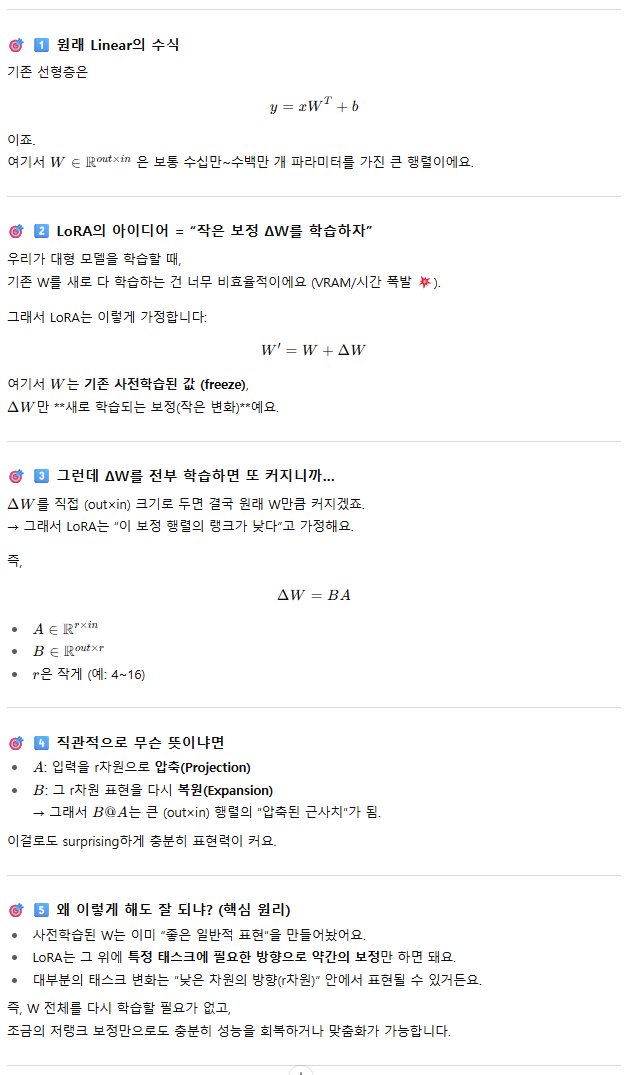
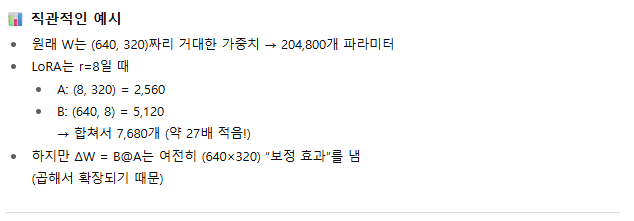

## *** "사전학습된 W와 새로 학습할 데이터의 성격이 완전 틀리면 효과가 없을까??" ***
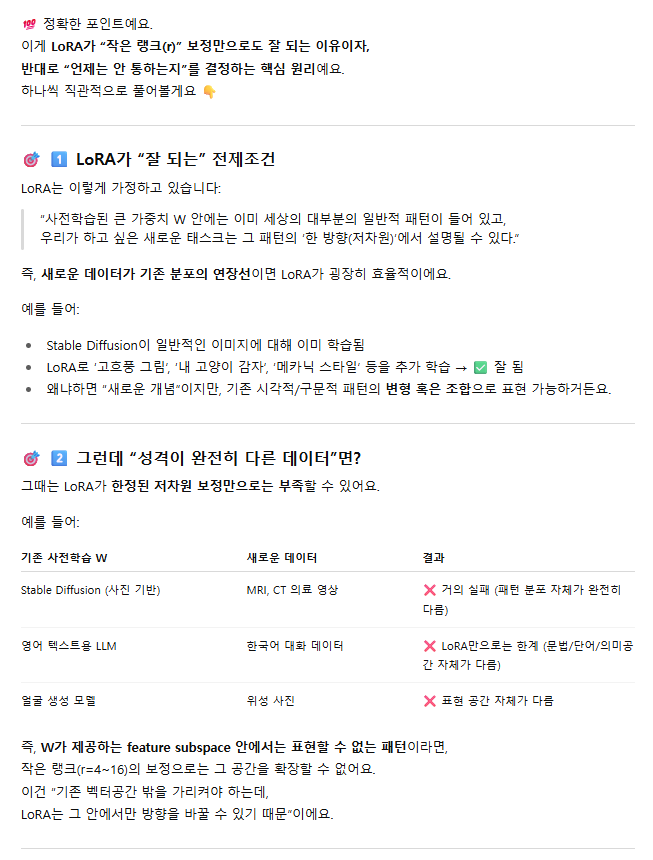
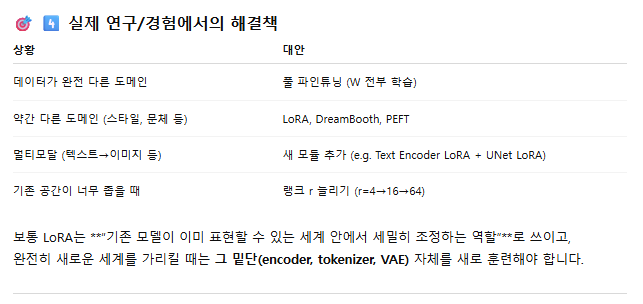

In [55]:
# --- 타깃 필터: 경로의 마지막 토큰으로 판단 ---

_PAT = re.compile(r"(in_proj|out_proj|q_proj|k_proj|v_proj)$")
def attn_name_filter(full_name: str, sub: nn.Module) -> bool:
    if not isinstance(sub, nn.Linear):
        return False
    last = full_name.split(".")[-1]
    return bool(_PAT.match(last))
    

# --- 교체기: named_children() 재귀 + 풀경로 누적(prefix) ---

def replace_linear_with_lora(module: nn.Module,
                             name_filter,
                             r=8, alpha=8, dropout=0.0,
                             prefix: str = "") -> int:
    replaced = 0
    for child_name, child in list(module.named_children()):
        full = f"{prefix}.{child_name}" if prefix else child_name

        # 아래로 먼저 탐색/교체
        replaced += replace_linear_with_lora(child, name_filter, r, alpha, dropout, prefix=full)

        # 이 레벨의 child가 타깃이면 교체
        if name_filter(full, child):
            if not isinstance(child, LoRALinear):
                setattr(module, child_name, LoRALinear(child, r=r, alpha=alpha, dropout=dropout))
                    ### setattr 동작원리 (파이썬 기본기)
                        # setattr(obj, "attr", value)는 obj.attr = value와 동등해요.
                        # 차이는 "attr"을 문자열로 동적으로 넣을 수 있다는 점. (루프에서 이름이 바뀌어도 처리 가능)
                replaced += 1
    return replaced
        

In [56]:
# --- 실무 포인트 ---
# new = LoRALinear(child, r=r, alpha=alpha, dropout=dropout)

# # 1) train/eval 모드 유지
# new.train(child.training)

# # 2) 디바이스/ dtype 맞추기
# device = next(child.parameters()).device if any(p.requires_grad for p in child.parameters()) else getattr(child, 'weight', None).device
# dtype  = next(child.parameters()).dtype  if any(p.requires_grad for p in child.parameters()) else getattr(child, 'weight', None).dtype
# new.to(device=device, dtype=dtype)

# # 3) 실제 교체
# setattr(module, child_name, new)

In [57]:
# # LoRA 파라미터만 학습 켜기
# for p in unet.parameters(): p.requires_grad = False
# for m in unet.modules():
#     if isinstance(m, LoRALinear):
#         m.A.requires_grad = True
#         m.B.requires_grad = True

# # 검증
# found = [name for name, m in unet.named_modules() if isinstance(m, LoRALinear)]
# print("LoRALinear modules found:", len(found))
# for s in found[:10]:
#     print("  ", s)

In [58]:
# --- LoRA 파라미터만 on ---
def enable_lora_only(module: nn.Module):
    for p in module.parameters(): p.requires_grad = False
    for m in module.modules():
        if isinstance(m, LoRALinear):
            m.A.requires_grad = True
            m.B.requires_grad = True

# --- LoRA 파라미터만 수집(optimizer/저장용) ---
def lora_parameters(module: nn.Module):
    for m in module.modules():
        if isinstance(m, LoRALinear):
            yield m.A
            yield m.B

# --- LoRA 저장/로드 (A/B만) ---
def state_dict_lora_only(module: nn.Module):
    sd = {}
    for name, m in module.named_modules():
        if isinstance(m, LoRALinear):
            sd[f"{name}.A"] = m.A.detach().cpu()
            sd[f"{name}.B"] = m.B.detach().cpu()
            # scaling(alpha/r)는 고정값이면 저장 생략 가능(다르면 함께 저장)
            sd[f"{name}.scaling"] = torch.tensor(m.scaling)
    return sd

def load_state_dict_lora_only(module: nn.Module, lora_sd: dict):
    for name, m in module.named_modules():
        if isinstance(m, LoRALinear):
            if f"{name}.A" in lora_sd:
                m.A.data.copy_(lora_sd[f"{name}.A"])
                m.B.data.copy_(lora_sd[f"{name}.B"])
            if f"{name}.scaling" in lora_sd:
                m.scaling = float(lora_sd[f"{name}.scaling"])
            

In [67]:
import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random, math, json, os
import numpy as np

### 0) 준비: 일정/스케줄(DDPM과 동일)
# 레포의 DDPMSampler와 동일한 베타 스케줄을 써서 alphas_cumprod(ᾱ_t) 만들기
def make_alphas_cumprod(num_training_steps=1000, beta_start=0.00085, beta_end=0.0120, device="cuda"):
    betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_training_steps, dtype=torch.float32, device=device)**2
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)  # ᾱ_t
    return betas, alphas, alphas_cumprod

### 1) 데이터셋 (이미지·캡션)
class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, image_root, width=512, height=512):
        """
        pairs: [(rel_path, caption), ...]
        image_root: 이미지 폴더
        """
        self.pairs = pairs
        self.root = image_root
        self.W, self.H = width, height

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rel_path, caption = self.pairs[idx]
        img = Image.open(os.path.join(self.root, rel_path)).convert("RGB").resize((self.W, self.H))
        x = torch.from_numpy(np.array(img)).float()   # (H,W,3)
        # (0,255)→(-1,1)
        x = (x / 255.0) * 2 - 1
        x = x.permute(2, 0, 1)                        # (3,H,W)

        return x, caption
        
### 2) 학습 루프 (핵심)
def train_diffusion(
    models,          # preload_models_from_standard_weights(...) 결과 dict
    tokenizer,       # CLIPTokenizer
    device="cuda",
    steps=10000,
        # 한 번의 step = (이미지 배치 → z_t 만들기 → U-Net 추론 → loss 역전파 → optimizer.step()) 한 사이클
        # steps = 위 사이클을 총 몇 번 수행할지를 정하는 하드 캡 
    batch_size=2,
    lr=1e-4,
    num_training_steps=1000,    # DDPM T
    image_root="../dataset/images", pairs=None,
):
    clip = models["clip"].to(device).eval().requires_grad_(False)         # CLIP을 추론 모드로 두고, 파라미터를 완전히 고정
        # requires_grad_(False)는 그라디언트 계산/저장 비활성화
        # .eval()은 Dropout/BatchNorm 등 추론 모드 동작만 바꾸고, 그라디언트 계산 여부는 바꾸지 않아요.
    
    encoder = models["encoder"].to(device).eval().requires_grad_(False)   # VAE Encoder freeze
    decoder = models["decoder"].to(device).eval().requires_grad_(False)   # (학습엔 안 씀, 검증용)
    diffusion = models["diffusion"].to(device).train()                    # <- 학습 대상 !!!

    # # 옵티마이저: Diffusion 파라미터만
    # optimizer = optim.AdamW(diffusion.parameters(), lr=lr)
    # ★ LoRA 전용 옵티마이저
    unet = diffusion.unet
    optimizer = optim.AdamW(lora_parameters(unet), lr=lr)

    # 스케줄 파라미터(ᾱ_t)
    betas, alphas, alphas_cumprod = make_alphas_cumprod(num_training_steps=num_training_steps, device=device)

    # pairs = [("img1.jpg", "a cat ..."), ...]
    assert pairs is not None and len(pairs) > 0, "pairs가 비어있습니다."
    dataset = ImageCaptionDataset(pairs, image_root=image_root, width=512, height=512)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)  # 실무에선 num_workers=4 

    H, W = 512, 512
    h, w = H//8, W//8

    step_count = 0
    while step_count < steps:
        for images, captions in loader:
            step_count += 1
            if step_count > steps: break

            images = images.to(device)     # (B,3,512,512)

            # ----- 1) 이미지 → latent z0 (VAE 인코더, 평균만; encoder_noise=0) -----
            with torch.no_grad():
                B = images.size(0)
                encoder_noise = torch.zeros((B, 4, h, w), device=device, dtype=images.dtype)
                    # **의도적으로 zeros를 넣어 “평균(latent mean)만 쓰는 결정적 인코딩”**
                    # 왜 평균만 쓰나요? -> 분산을 사용안하여 latent를 고정시켜 확산 노이즈만 통제해서 학습하려고 VAE 샘플링 노이즈는 꺼둔 것
                    # 언제 randn을 쓰나요? -> VAE 자체를 훈련할 때
                z0 = encoder(images, encoder_noise)    # (B,4,h,w), 이미 0.18215 스케일 적용됨 (레포 인코더 로직 기준)

            # ----- 2) t 샘플 + 노이즈 주입 (배치 단일 t로 간단히) -----
            t = torch.randint(low=0, high=num_training_steps, size=(1,), device=device).item()   # 스칼라 t
            alpha_bar_t = alphas_cumprod[t]
            sqrt_ab = alpha_bar_t.sqrt()
            sqrt_omab = (1 - alpha_bar_t).sqrt()

            eps = torch.randn_like(z0)            # 정답 노이즈 ε
            zt = sqrt_ab * z0 + sqrt_omab * eps   # (B,4,h,w)

            # ----- 3) 텍스트 → CLIP 컨텍스트 -----
            token_ids = tokenizer.batch_encode_plus(list(captions), padding="max_length", max_length=77).input_ids
            tokens = torch.tensor(token_ids, dtype=torch.long, device=device)     # (B, 77)
            with torch.no_grad():
                context = clip(tokens)            # (B,77,768)

            # ----- 4) 시간 임베딩 (레포 함수 그대로; 배치 단일 t) -----
            time_emb_320 = get_time_embedding(t).to(device)                       # (1,320)
                # 향후 Diffusion.forward 내부에서 TimeEmbedding MLP로 (1,1280) 변환됨

            # ----- 5) U-Net 전향 & 손실 -----
            pred_eps = diffusion(zt, context, time_emb_320)                       # (B,4,h,w)  ← 예측 노이즈 ε̂
            loss = F.mse_loss(pred_eps, eps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step_count % 50 == 0:
                print(f"[step {step_count}] loss={loss.item():.4f}")
                
# 📈 개선 팁 (선택사항)
# 항목	권장 설정	이유
# lr	1e-4 → 5e-5 로 낮춰보기	후반 안정성 개선
# batch_size	2 → 4 가능하면 증가	손실 진동 완화
# steps	5,000~10,000	LoRA는 수렴 빨라서 5k면 충분하지만 더 미세조정 원하면 10k

In [71]:
import os, json

def load_pairs(jsonl_path: str, image_root: str, allow_missing: bool = False):
    """
    captions.jsonl을 읽어 [(rel_path, caption), ...] 리스트로 반환.
    각 줄은 {"path":"images/0001.jpg","caption":"..."} 형식.
    image_root/rel_path 파일 존재 여부를 검사(allow_missing=False일 때 누락 파일은 스킵).
    """
    pairs = []
    n_total = 0
    n_missing = 0
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            n_total += 1
            obj = json.loads(line)
            rel = obj["path"]
            cap = obj["caption"]
            full = os.path.join(image_root, rel)
            if not os.path.isfile(full):
                n_missing += 1
                if not allow_missing:
                    # 누락 파일은 스킵 (필요하면 warn만 출력하고 포함시킬 수 있음)
                    print(f"[WARN] missing image: {full}")
                    continue
            pairs.append((rel, cap))
    print(f"[INFO] loaded {len(pairs)}/{n_total} pairs (missing={n_missing})")
    return pairs


In [75]:
from transformers import CLIPTokenizer

image_root = "../dataset"                     # 이미지가 들어있는 루트
jsonl_path = "../dataset/captions.jsonl"      # {"path":"images/0001.jpg","caption":"..."} 줄들이 있는 파일
pairs = load_pairs(jsonl_path, image_root)


DEVICE = "cuda"  # 또는 "cpu"
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
models = preload_models_from_standard_weights("../data/v1-5-pruned-emaonly.ckpt", DEVICE)

### 1) 주입: 학습 시작 전 UNet에 LoRA 꽂기
unet = models["diffusion"].unet
n = replace_linear_with_lora(unet, attn_name_filter, r=8, alpha=8, dropout=0.0)
print("LoRA replaced:", n)

enable_lora_only(unet)  # LoRA 파라미터만 학습되게

[INFO] loaded 50/50 pairs (missing=0)
LoRA replaced: 96


In [77]:
train_diffusion(
    models=models,
    tokenizer=tokenizer,
    device=DEVICE,
    steps=5000,          # 총 학습 스텝
    batch_size=2,        # VRAM에 맞춰 조절
    lr=1e-4,             # 시작은 1e-4 권장(필요시 5e-5)
    num_training_steps=1000,  # 스케줄 길이(베타 스케줄과 맞춤)
    image_root=image_root,   # ← 여기!
    pairs=pairs,             # ← 여기!
)

[step 50] loss=0.0032
[step 100] loss=0.0393
[step 150] loss=0.1491
[step 200] loss=0.1907
[step 250] loss=0.1464
[step 300] loss=0.0072
[step 350] loss=0.0126
[step 400] loss=0.0641
[step 450] loss=0.9164
[step 500] loss=0.0615
[step 550] loss=0.0084
[step 600] loss=0.1550
[step 650] loss=0.2864
[step 700] loss=0.6978
[step 750] loss=0.0040
[step 800] loss=0.1463
[step 850] loss=0.0662
[step 900] loss=0.1901
[step 950] loss=0.0844
[step 1000] loss=0.0274
[step 1050] loss=0.3745
[step 1100] loss=0.2530
[step 1150] loss=0.0029
[step 1200] loss=0.0093
[step 1250] loss=0.0121
[step 1300] loss=0.0318
[step 1350] loss=0.0543
[step 1400] loss=0.2516
[step 1450] loss=0.0069
[step 1500] loss=0.1597
[step 1550] loss=0.0542
[step 1600] loss=0.1007
[step 1650] loss=0.1492
[step 1700] loss=0.0569
[step 1750] loss=0.4505
[step 1800] loss=0.0635
[step 1850] loss=0.0810
[step 1900] loss=0.1597
[step 1950] loss=0.5376
[step 2000] loss=0.0179
[step 2050] loss=0.0711
[step 2100] loss=0.0052
[step 2150] 

In [79]:
# 학습 완료 후 저장 (Diffusion만 저장; 나중에 불러올 때 이 가중치로 교체)
# LoRA만 저장:

torch.save(state_dict_lora_only(models["diffusion"].unet), "unet_lora.pt")

# CLIP도 했다면 별도 저장:
# torch.save(state_dict_lora_only(models["clip"]), "clip_lora.pt")
            

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.75it/s]


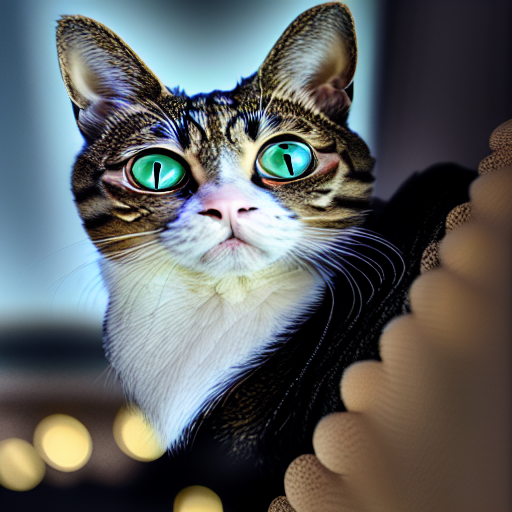

In [83]:
### 프롬프트 예시:
# 기본: gamjacat, a cat
# 배경/분위기: gamjacat, a cat, on the floor indoors, natural light
# 스타일: gamjacat, a cat, studio portrait, 85mm lens, softbox lighting
# 그림체: a watercolor painting of gamjacat, a cat

prompt = "gamjacat, a cat, highly detailed, ultra sharp, cinematic lighting"
uncond_prompt = ""  # "blurry, low quality, extra limbs, watermark"  # 선택
do_cfg = True
cfg_scale = 7.5  # 6.5~8.5 사이 튜닝 추천

# 텍스트-투-이미지니까 입력 이미지 끄기
input_image = None

## IMAGE TO IMAGE
# image_path = "../images/sample_dog.jpg"
# input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 1.0  # 무시됨 # 아무 의미 없이 통과용 (0<strength<=1)

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.02it/s]


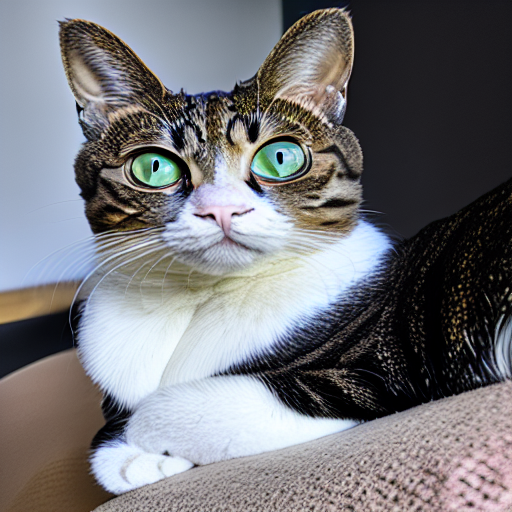

In [113]:
### 프롬프트 예시:
# 기본: gamjacat, a cat
# 배경/분위기: gamjacat, a cat, on the floor indoors, natural light
# 스타일: gamjacat, a cat, studio portrait, 85mm lens, softbox lighting
# 그림체: a watercolor painting of gamjacat, a cat

prompt = "a photo of gamjacat, a cat, in a sitting pose, highly detailed, ultra sharp, cinematic lighting"
uncond_prompt = "blurry, low quality, extra limbs, watermark"  # "blurry, low quality, extra limbs, watermark"  # 선택
do_cfg = True
cfg_scale = 7.5  # 6.5~8.5 사이 튜닝 추천

# 텍스트-투-이미지니까 입력 이미지 끄기
input_image = None

## IMAGE TO IMAGE
# image_path = "../images/sample_dog.jpg"
# input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 1.0  # 무시됨 # 아무 의미 없이 통과용 (0<strength<=1)

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.57it/s]


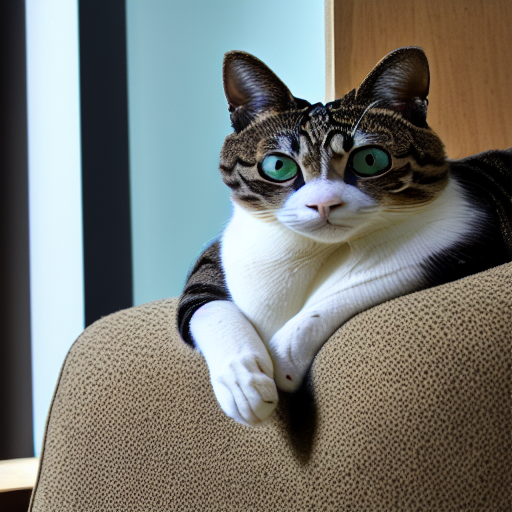

In [95]:
### 프롬프트 예시:
# 기본: gamjacat, a cat
# 배경/분위기: gamjacat, a cat, on the floor indoors, natural light
# 스타일: gamjacat, a cat, studio portrait, 85mm lens, softbox lighting
# 그림체: a watercolor painting of gamjacat, a cat

prompt = "gamjacat, a cat, sitting on a sofa indoors, natural light, highly detailed, ultra sharp"
uncond_prompt = ""  # "blurry, low quality, extra limbs, watermark"  # 선택
do_cfg = True
cfg_scale = 7.5  # 6.5~8.5 사이 튜닝 추천

# 텍스트-투-이미지니까 입력 이미지 끄기
input_image = None

## IMAGE TO IMAGE
# image_path = "../images/sample_dog.jpg"
# input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 1.0  # 무시됨 # 아무 의미 없이 통과용 (0<strength<=1)

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.09it/s]


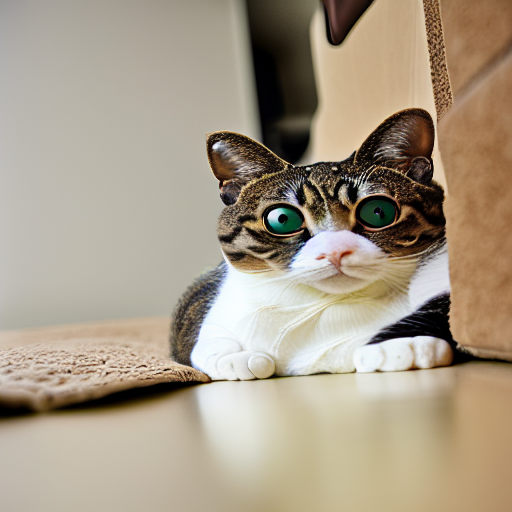

In [126]:
### 프롬프트 예시:
# 기본: gamjacat, a cat
# 배경/분위기: gamjacat, a cat, on the floor indoors, natural light
# 스타일: gamjacat, a cat, studio portrait, 85mm lens, softbox lighting
# 그림체: a watercolor painting of gamjacat, a cat

# 동작이 잘 안 먹을 때 대안:
# img2img: 비슷한 포즈의 감자 사진을 넣고 strength=0.3–0.6으로 조절

prompt = "gamjacat, a cat, lying on the floor indoors, studio lighting, 85mm lens"
uncond_prompt = "blurry, low quality, extra limbs, watermark"  # "blurry, low quality, extra limbs, watermark"  # 선택
do_cfg = True
cfg_scale = 7.5  # 6.5~8.5 사이 튜닝 추천

# 텍스트-투-이미지니까 입력 이미지 끄기
# input_image = None

## IMAGE TO IMAGE
image_path = "../images/lying_cat.jpg"
input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.85  # 무시됨 # 아무 의미 없이 통과용 (0<strength<=1)

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [ ]:
# ### ---------------- 새 세션/프로세스에서 추론 ----------------
# # 베이스 모델 로드
# models = preload_models_from_standard_weights("../data/v1-5-pruned-emaonly.ckpt", DEVICE)

# # UNet에 LoRA 주입 후 A/B 로드
# unet = models["diffusion"].unet
# _ = replace_linear_with_lora(unet, attn_name_filter, r=8, alpha=8, dropout=0.0)
# load_state_dict_lora_only(unet, torch.load("unet_lora.pt", map_location=DEVICE))

# # 그대로 generate
# prompt="gamjacat, a cat"
# img = generate(
#     prompt=prompt,
#     do_cfg=True, cfg_scale=7.5,
#     sampler_name="ddpm", n_inference_steps=50,
#     models=models, device=DEVICE, idle_device="cpu",
#     tokenizer=tokenizer,
# )
# Image.fromarray(img)

# 검토의견
- LoRA는 정체성(감자의 얼굴, 털색, 질감) 학습에 특화 → 자세/동작 재현은 약함
- LoRA의 한계라기보단 설계 목적의 차이: “모양 유지 + 스타일 교체용”이지, “자세 제어용”은 아님
# 해결방법
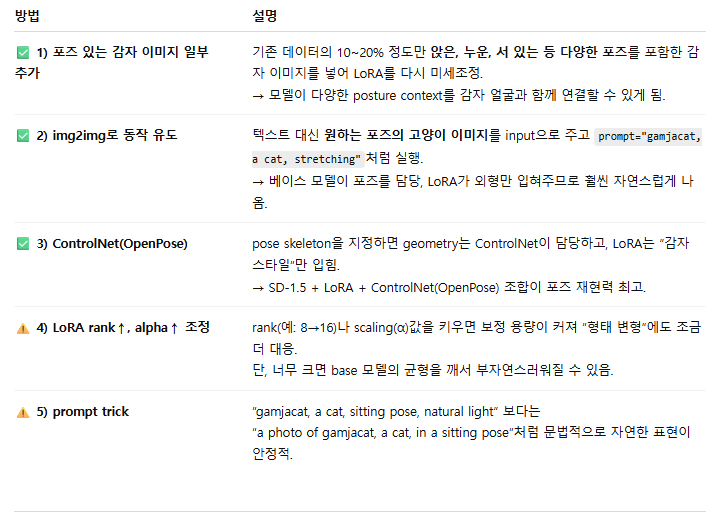